# Batch Processing of Plots using the Selection for Data

NUE SELECTION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

## NUE_NUE SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['tksh_angle', 'slnhits', 'shr_distance', 'shrsubclusters0', 'shrsubclusters1', 'nproton', 'flash_time', 'reco_nu_vtx_sce_z', 'evt', 'shr_energy', 'reco_nu_vtx_sce_y', 'n_showers_contained', 'shr_phi', 'category', 'shr_px', 'shr_tkfit_npoints', 'ccnc', 'contained_fraction', 'reco_nu_vtx_sce_x', 'nslice', 'sub', 'trkshrhitdist2', 'shr_tkfit_dedx_Y', 'selected', 'shr_tkfit_dedx_V', 'shr_score', 'n_tracks', 'shr_tkfit_nhits_V', 'n_tracks_contained', 'shrsubclusters2', 'shr_theta', 'shr_tkfit_nhits_U', 'n_showers', 'shrmoliereavg', 'npion', 'trk_energy', 'shr_tkfit_dedx_U', 'shr_pz', 'topological_score', 'shr_energy_cali', 'trk_score_v', 'shr_tkfit_nhits_Y', 'nu_pdg', 'run', 'trk_energy_tot', 'slnunhits', 'CosmicIPAll3D', 'shr_energy_tot_cali', 'shr_py', 'hits_ratio', 'tksh_distance']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

beamon_pot = 2.0E20 #v5
nue_intrinsic_pot = 2.37838E22 #matches Alex

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [8]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['weightSplineTimesTuneTimesPPFX']

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [11]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [11]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  18.795923471450806


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [16]:
"""
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
"""

In [15]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [16]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [17]:
#Define signal catagories

#nue_nue["is_signal"] = nue_nue["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [18]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for Selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 103)


In [22]:
test = np.nansum(nue_nue.query(BDT_LOOSE_CUTS)["weightSplineTimesTuneTimesPPFX"])
print('total signal events = '+ str(test))

total signal events = 13083.174


In [23]:
datasets_bdt = nue_nue

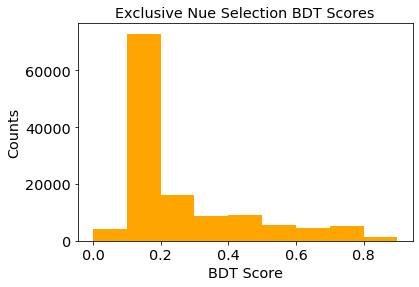

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [25]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
 

In [26]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUE_SEL_QUERY += ' and nu_e > 0.04 and nu_e < 5'

#NUE_SIMPLE_QUERY = 'nslice==1'
#NUE_SIMPLE_QUERY += ' and ' + reco_in_fv_query
#NUE_SIMPLE_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'

In [27]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 65.13958090873197


In [28]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY + 'and is_signal==True')['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 56.99571519411816


In [29]:
test = np.nansum(datasets_bdt.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 56.99571519411816


In [30]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY + 'and category==11')['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 56.99571519411816


In [31]:
#truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
#truthsel_nue  += " and category == 11"
#truthsel_nue += ' and reco_e > 0.04 and reco_e < 5'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  127551
n_events/2 here =  25510.0

1.0
1
127551
{'nue_nue': 1}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[0.01028306 0.00998801 0.01302625 ... 0.00871911 0.00935456 0.00879623]
TEST
1
2
3
current_total  65.13958090873197
65.139580908731971931047155521810054779052734375000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  65.13958090873197
65.139580908731971931047155521810054779052734375000000000000000000000000000000
------------

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
0
{'nue_nue': 1}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[]
Had to return early (colour sorting).


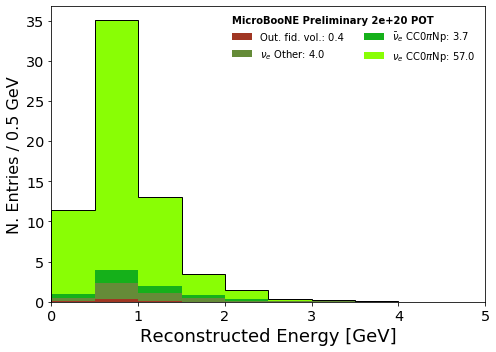

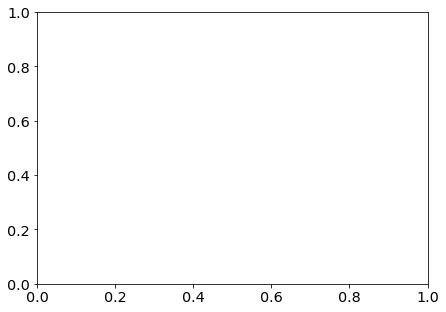

In [33]:
#WHAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                #"nue_nue"  : nueratio  * SPLIT * scaling
                "nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query=BDT_LOOSE_CUTS,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX",
        genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  127551
n_events/2 here =  25510.0

1.0
1
127551
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[1.2228513 1.1877642 1.5490692 ... 1.1190536 1.0368681 1.1124349]
TEST
1
2
3
current_total  56.99571519411816
56.995715194118162116865278221666812896728515625000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  56.99571519411816
56.99571519411816211686527822166681289672851562500000000000

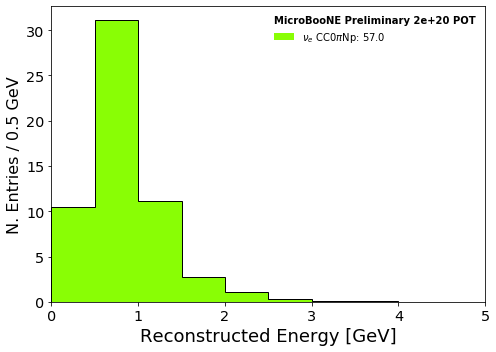

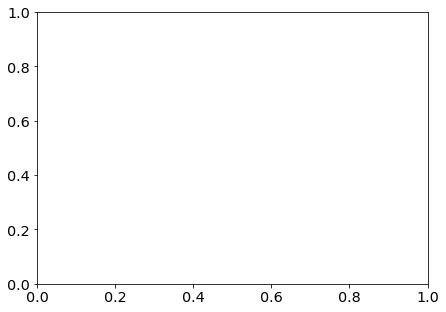

In [34]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUE_SEL_QUERY,
        #query=BDT_LOOSE_CUTS,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


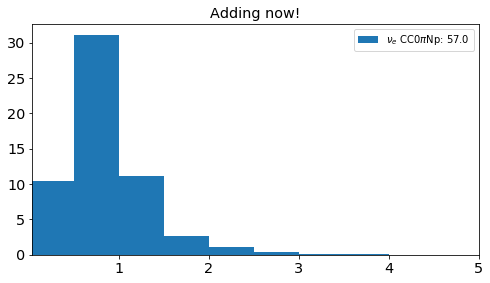

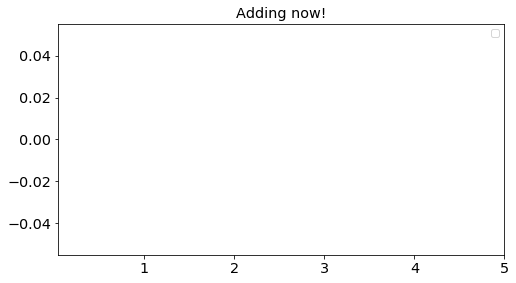

In [35]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0.04, 5.0])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [36]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

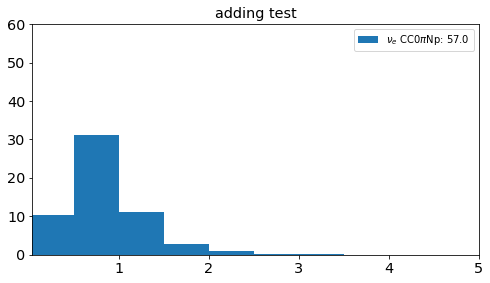

In [37]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0.04, 5.0])
nue_ax1.set_ylim([0, 60])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 35])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()


#print('%.75f' % sum(nue_stacked[0]))
#print(nue_stacked[0])

In [38]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1   #2

nue_wanted_list = nue_stacked[0]
#nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)
print(sum(nue_wanted_list))
print('%.75f' % nue_wanted_list[9])

[1.04492241e+01 3.10782484e+01 1.11426725e+01 2.72081822e+00
 1.06264234e+00 3.26019952e-01 1.36951406e-01 5.99659714e-02
 9.51532401e-03 9.65695389e-03]
56.99571519411813
0.009656953892241771156279561694191215792670845985412597656250000000000000000


In [37]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

if (is_selected == True):
    ######full trueE
    vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv')
    weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif (is_selected == False):
    ######full trueE
    vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_07Jul.csv')
    weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_07Jul.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Errors

In [38]:
#This is the stat errors on the selected signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  127551
n_events/2 here =  63775.0

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[8.09660569e-02 2.27694937e-01 8.14610459e-02 2.17088030e-02
 7.84911120e-03 2.47494497e-03 1.06069070e-03 4.94988994e-04
 7.07127135e-05 7.07127135e-05]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1.04492235e+01 3.10782471e+01 1.11426716e+01 2.72081804e+00
 1.06264234e+00 3.26019943e-01 1.36951402e-01 5.99659681e-

In [39]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.0809660569470748, 0.22769493744068198, 0.08146104594151107, 0.021708803041704774, 0.007849111197489348, 0.0024749449721813256, 0.0010606907023634254, 0.0004949889944362651, 7.071271349089502e-05, 7.071271349089502e-05]

total selected =  [10.449223518371582, 31.0782470703125, 11.142671585083008, 2.720818042755127, 1.0626423358917236, 0.32601994276046753, 0.13695140182971954, 0.05996596813201904, 0.009515323676168919, 0.009656953625380993]


In [40]:

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####angleDiff###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

In [41]:
#This is the stat errors on the selected NOT signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  127551
n_events/2 here =  63775.0

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5and is_signal==False& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[0.00636414 0.02941649 0.01619321 0.00643486 0.0027578  0.00070713
 0.0005657  0.00028285 0.         0.        ]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.925597   3.9531963  1.9469239  0.79858434 0.35140404 0.07013565
 0.0589308  0.03909332 0.         0.        ]
Returning
{'nue_nue': 0.008409085175623745}
ns

In [42]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.006364144214180553, 0.029416488812212333, 0.01619321138941496, 0.0064348569276714476, 0.002757795826144906, 0.0007071271349089503, 0.0005657017079271602, 0.0002828508539635801, 0.0, 0.0]

total selected =  [0.9255970120429993, 3.9531962871551514, 1.946923851966858, 0.7985843420028687, 0.3514040410518646, 0.07013564556837082, 0.05893079936504364, 0.039093323051929474, 0.0, 0.0]


In [43]:

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_07Jul.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_07Jul.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####angleDiff###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors

In [39]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  127551
n_events/2 here =  63775.0

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1012  1029  1028  1006  1061  1036  1036  1044  1046  1005  ...  1027   
1      369  4609  2715  1717   334    45   269   583  1578    59  ...  2474   
2     1464   299   824   561  1183  1225  2529  1133   893   606  ...  1369   
3      829   953  1091   600   839   666   991  1005   764   793  

In [49]:
detvar_dicts[0]

{'CV': [11.374821,
  35.031445,
  13.089596,
  3.5194025,
  1.4140463,
  0.3961556,
  0.1958822,
  0.09905929,
  0.009515324,
  0.009656954],
 0: [11.516186187855778,
  34.58189197370757,
  12.562229746702805,
  3.555893142404587,
  1.3653051059967158,
  0.4396928669236585,
  0.16685633140243586,
  0.09551718343980611,
  0.011465965029783547,
  0.0023466397309675814],
 1: [12.012353677217654,
  37.94273454144211,
  14.871631972517873,
  3.7668965895796664,
  1.5284993242851237,
  0.4238440793066984,
  0.16218407749477776,
  0.10257564113941045,
  0.004443656156770885,
  0.0038724384037777783],
 2: [11.906659671485867,
  36.2756878582166,
  14.022087275750133,
  3.8230525673614766,
  1.5578585554971212,
  0.429133021939142,
  0.19456949511123817,
  0.10618378804204985,
  0.0107142544593662,
  0.00650878674350679],
 3: [8.415978802604176,
  27.501657435873582,
  10.726560991792889,
  3.1679008204138372,
  1.2853289753990689,
  0.31741043099628596,
  0.16060080537805335,
  0.0821660570115

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.13748207e+01 3.50314445e+01 1.30895958e+01 3.51940155e+00
 1.41404343e+00 3.96156311e-01 1.95884705e-01 9.90600586e-02
 9.51385498e-03 9.65881348e-03]


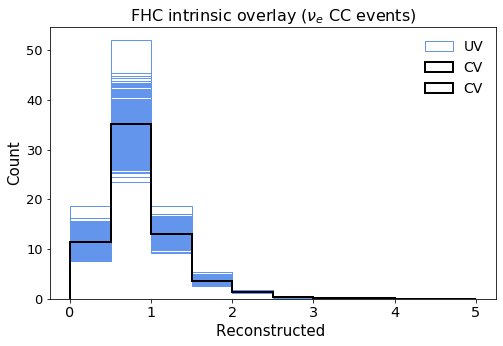

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


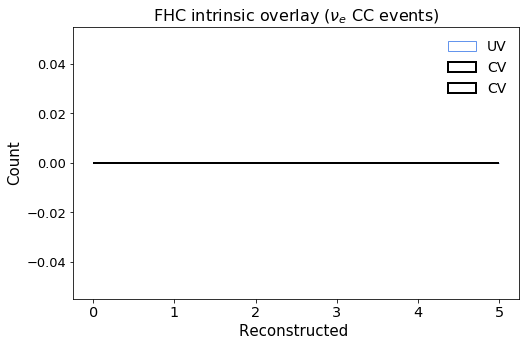

In [40]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [50]:
#will need to edit this if batching

nue_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [47]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
print(total_ppfx_df_splines)

entry
1         0.010283
27        0.009988
50        0.013026
91        0.007278
96        0.010667
            ...   
127475    0.008346
127480    0.009410
127484    0.008719
127519    0.009355
127532    0.008796
Name: weightSplineTimesTuneTimesPPFX, Length: 6881, dtype: float32


In [59]:

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#################################
#####leptonMom##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################################\n#####leptonMom##################\n############################\n\nnp.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_nue_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_nue_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSel

In [51]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  127551
n_events/2 here =  63775.0

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1350  1065   879  1283  1097  1400  1154  1186  1305  1306  ...  1361   
1     1340   381   401  1810   933   666  1530   504  1940   553  ...  1346   
2     1336  1068   889  1270  1099  1376  1153  1174  1289  1297  ...  1346   
3      753   926   405  1005   541  1014   883  1143   909  1229  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.13748207e+01 3.50314445e+01 1.30895958e+01 3.51940155e+00
 1.41404343e+00 3.96156311e-01 1.95884705e-01 9.90600586e-02
 9.51385498e-03 9.65881348e-03]


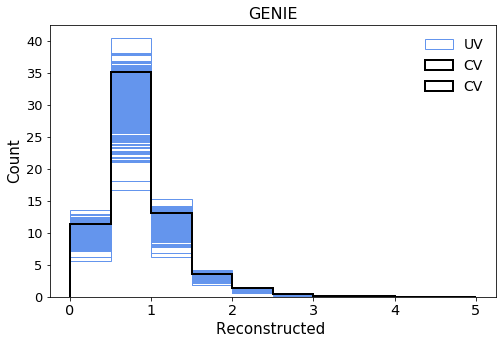

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


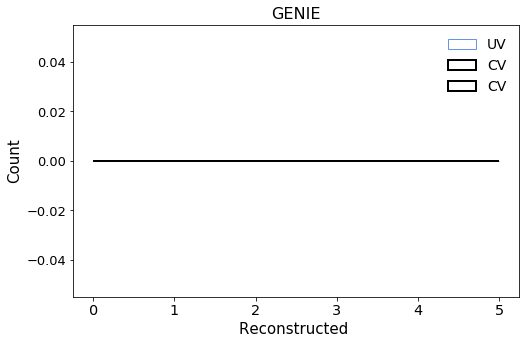

In [52]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [53]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [61]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [62]:

np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""

#####################
###AngleDiff###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom###\n######################\nnp.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_nue_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_nue_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_vars.to_csv(\'nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_splines.to_csv(\'nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [54]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#this time = nevents
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  127551
n_events/2 here =  63775.0
weightsReint
1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1052  1120  1015   985  1121  1002   918  1024   915  1062  ...   982   
1      930   814   865  1021   833  1004  1143   972  1098   912  ...  1031   
2      977   932  1040  1003   964   987   982   982  1030   984  ...   965   
3      970   928   798  1015   888  1030  1193  1004  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.13748207e+01 3.50314445e+01 1.30895958e+01 3.51940155e+00
 1.41404343e+00 3.96156311e-01 1.95884705e-01 9.90600586e-02
 9.51385498e-03 9.65881348e-03]


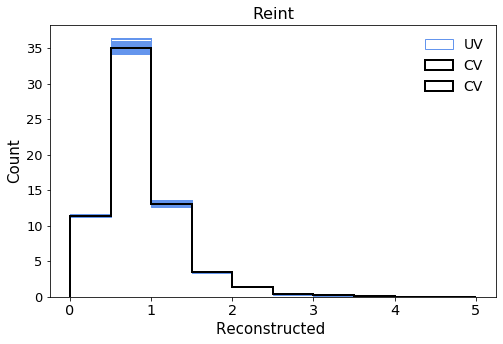

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


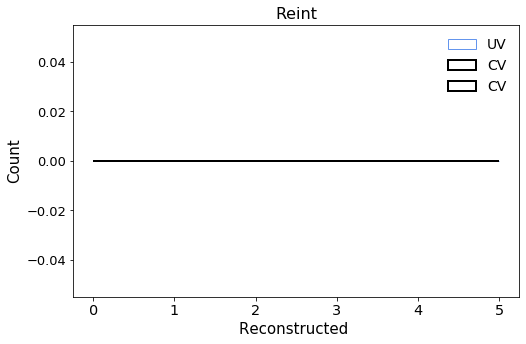

In [55]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [56]:
#will need to edit this if batching

nue_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [34]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)
print(final_ncvs_nue_nue_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)

[1.13748207e+01 3.50314445e+01 1.30895958e+01 3.53603458e+00
 1.41404629e+00 4.08662528e-01 2.09075719e-01 1.19576305e-01
 2.03033201e-02 2.89523061e-02]
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1052  1120  1015   985  1121  1002   918  1024   915  1062  ...   982   
1      930   814   865  1021   833  1004  1143   972  1098   912  ...  1031   
2      977   932  1040  1003   964   987   982   982  1030   984  ...   965   
3      970   928   798  1015   888  1030  1193  1004  1041   936  ...  1108   
4      988   930  1104   995  1005   974   898   980   995  1012  ...   912   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6886  1074  1186   991   981  1161  1011   922  1038   891  1079  ...  1003   
6887   918   779  1122  1013   865   961   967   942  1118   939  ...   902   
6888   985   956  1028  1001   979   991   984   988  1018   991  ...   974   
6889   982   946  1034  1002   973   989   982   986  10

In [65]:

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#################
###angleDiff#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

"""
#################
###leptonMom#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################\n###leptonMom#####\n#################\n\nnp.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_nue_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_nue_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_vars.to_csv(\'nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_splines.to_csv(\'nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [32]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#was I out of it choosing batch sizes?!
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  127551
n_events/2 here =  63775.0
1.0
2
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5 and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 an

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


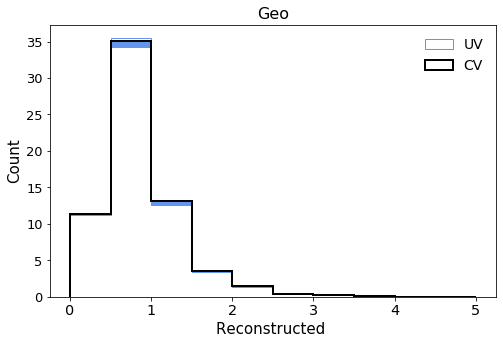

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


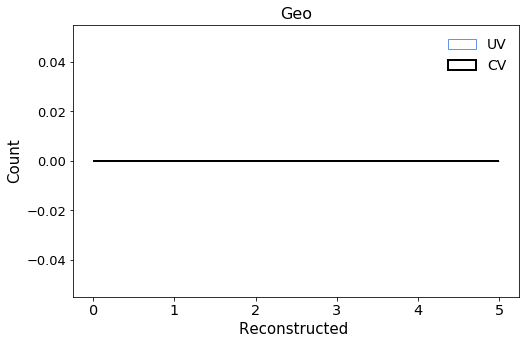

In [33]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [34]:
#will need to edit this if batching

nue_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [67]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [68]:

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#####################
###angleDiff########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom########\n####################\n\nnp.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_nue_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_nue_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#######################################################\n\ntotal_geo_df.to_csv(\'nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_vars.to_csv(\'nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_splines.to_csv(\'nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv\')\n'

## NUE_MC SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

#actually fetch datasets
nue_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc  = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['shr_score', 'reco_nu_vtx_sce_y', 'contained_fraction', 'trk_energy', 'shr_tkfit_nhits_Y', 'shr_phi', 'npion', 'trkshrhitdist2', 'shr_energy_tot_cali', 'topological_score', 'n_showers', 'flash_time', 'trk_score_v', 'shr_distance', 'shrmoliereavg', 'shrsubclusters0', 'n_tracks', 'reco_nu_vtx_sce_x', 'shr_energy_cali', 'shr_energy', 'tksh_angle', 'reco_nu_vtx_sce_z', 'CosmicIPAll3D', 'selected', 'nproton', 'shr_tkfit_dedx_U', 'n_tracks_contained', 'sub', 'shr_px', 'shrsubclusters1', 'shr_theta', 'shr_tkfit_npoints', 'evt', 'slnunhits', 'trk_energy_tot', 'shr_tkfit_nhits_U', 'nslice', 'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_V', 'shr_py', 'shr_tkfit_nhits_V', 'tksh_distance', 'shr_pz', 'ccnc', 'shrsubclusters2', 'run', 'slnhits', 'hits_ratio', 'n_showers_contained', 'nu_pdg', 'category']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

beamon_pot = 2.0E20 #v5
overlay_pot =  2.33652E21

nue_mc['pot_scale'] = beamon_pot/overlay_pot

In [8]:
nue_mc['totweight_data'] = nue_mc['pot_scale']*nue_mc['weightSplineTimesTuneTimesPPFX']

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [11]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  147.3340618610382


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [15]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
    

In [16]:
# add back the cosmic category, for background only
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [17]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [18]:
#Define signal catagories

nue_mc["is_signal"] = nue_mc["category"] == 11

In [19]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

In [20]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for selection.

In [21]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [22]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [23]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 121)


In [24]:
datasets_bdt = nue_mc

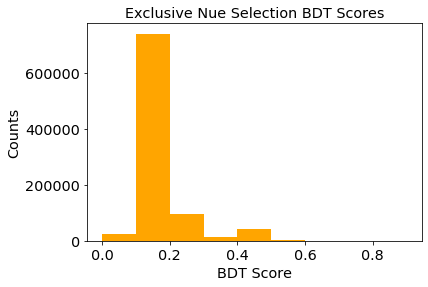

In [25]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [26]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

#NUE_SIMPLE_QUERY = 'nslice==1'
#NUE_SIMPLE_QUERY += ' and ' + reco_in_fv_query
#NUE_SIMPLE_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [27]:
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY + "and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 6.043582129255835


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  914729
n_events/2 here =  457364.0

1.0
1
0
914729
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
TEST
1
2
3
current_total  6.406481953009316
6.406481953009316221425706316949799656867980957031250000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  6.406481953009316
6.406481953009316221425706316949799656867980957031250000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  6

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
914729
0
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early (colour sorting).


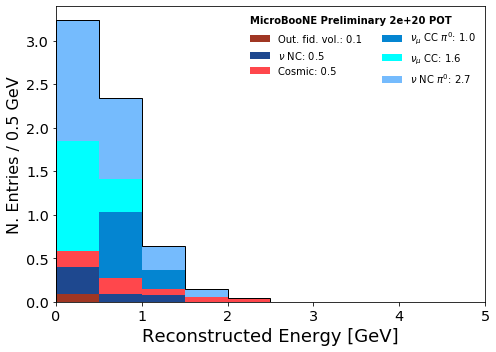

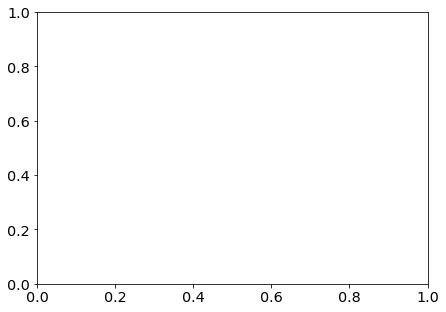

In [29]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/3.3))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # This is the full MC POT scaling factor
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21

    # NU
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


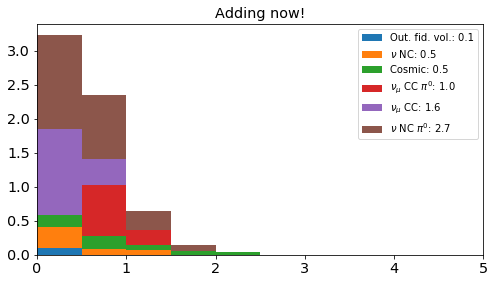

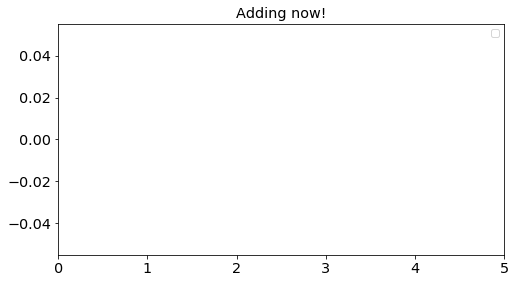

In [30]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [31]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

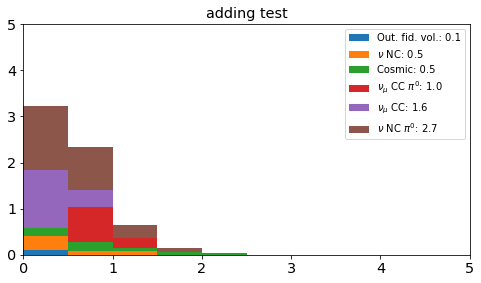

In [32]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 5])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 2])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [33]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.0, 0.0, 0.0, 0.0, 0.0]

SUMS
[0.09383747909215713, 0.5667739784442256, 1.0992005877360693, 2.06868340235577, 3.717531520127843, 6.406481953009317]
[0.4729364993520685, 0.5324266092918437, 0.9694828146197008, 1.648848117772073, 2.688950432881474]

Wanted List:
[1.2671151287008708, 0.381732989071202, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[1.2671151287008708, 0.381732989071202, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [34]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Errors

In [35]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729
n_events/2 here =  457364.0

1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

LOOK HERE FOR DETSYS
None
err nue mc: 
[0.24911501 0.22713428 0.05128839 0.01465382 0.00732691 0.
 0.         0.         0.         0.        ]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [3.060251   2.189677   0.62954164 0.11053932 0.05357302 0.
 0.         0.         0.         0.        ]
Returning
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sc

In [36]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [0.24911501385770116, 0.22713427734084515, 0.051288385205997294, 0.014653824344570656, 0.007326912172285328, 0.0, 0.0, 0.0, 0.0, 0.0]

total selected =  [3.060250997543335, 2.1896770000457764, 0.6295416355133057, 0.11053932458162308, 0.05357301980257034, 0.0, 0.0, 0.0, 0.0, 0.0]


In [37]:

np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""
#########################
#####angleDiff###########
##########################

np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####leptonMom###########
##########################
"""
np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\nnp.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_mc_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_mc_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors

In [28]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729
n_events/2 here =  457364.0

1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0    399   278   574   533   321   577   475   357   290   363  ...   290   
1   1773  1911  1903  1458  2018  1979  1815  1855  2004  1595  ...  1719   
2    944   867   894   749  1111   904   943  1138   917   866  ...   832   
3   1263   991  1134   844   727  1546  1115   459  1037  1542  ...  1459   
4    425

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[3.060251   2.189677   0.62954187 0.11053944 0.05357313 0.
 0.         0.         0.         0.        ]


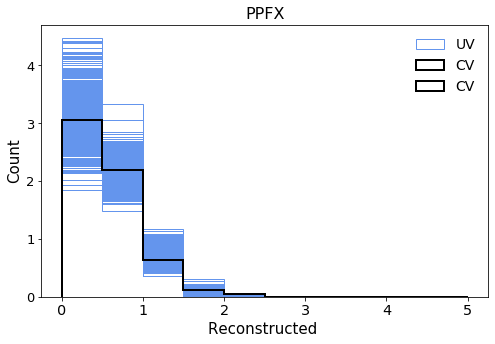

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


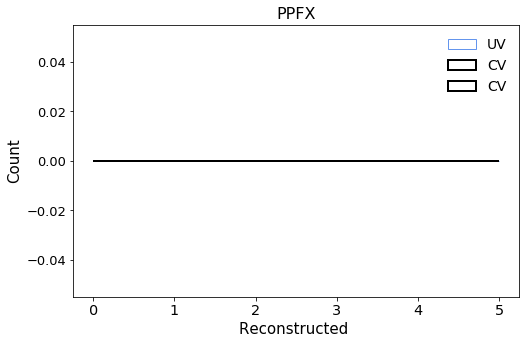

In [29]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [30]:
#will need to edit this if batching

nue_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [39]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [40]:

np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')


total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDif_usingSelectionf.csv')
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#################################
#####leptonMom##################
############################

np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################################\n#####leptonMom##################\n############################\n\nnp.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_mc_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_mc_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.

In [31]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }  


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729
n_events/2 here =  457364.0

1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0    782   392   522  1044   930   334  1169   408   726   341  ...   928   
1      1     1     1     1     1     1     1     1     1     1  ...     1   
2   1047  1190  1213   941   840   936   938   900  1019  1002  ...   903   
3    933  1597   912   672  2143   674  2195   677  1961  1054  ...   257   
4      0

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[3.060251   2.189677   0.62954187 0.11053944 0.05357313 0.
 0.         0.         0.         0.        ]


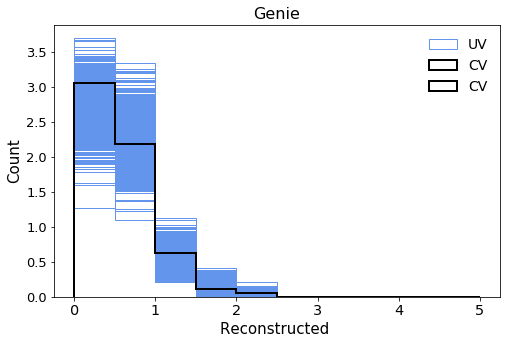

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


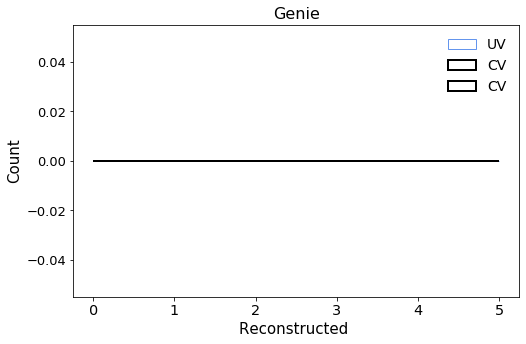

In [32]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [33]:
#will need to edit this if batching

nue_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [42]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_genie.append(sum(masterlist[a]))

final_ncvs_nue_mc_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)

In [43]:

np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#####################
###AngleDiff###
######################
np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom###
######################
np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom###\n######################\nnp.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_mc_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_mc_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_vars.to_csv(\'nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_splines.to_csv(\'nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [34]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729
n_events/2 here =  457364.0
weightsReint
1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
     0     1     2     3     4     5     6     7     8     9    ...   990  \
0    968   909  1051  1004   949   983   979   977  1042   978  ...   956   
1    974   930   823  1012   908  1023  1145  1002  1031   948  ...  1076   
2    911   761  1141  1014   857   957   956   936  1128   935  ...   889   
3   1063  1152  1003   983  1140  1006   920  1031   903  1070  ...   993

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[3.060251   2.189677   0.62954187 0.11053944 0.05357313 0.
 0.         0.         0.         0.        ]


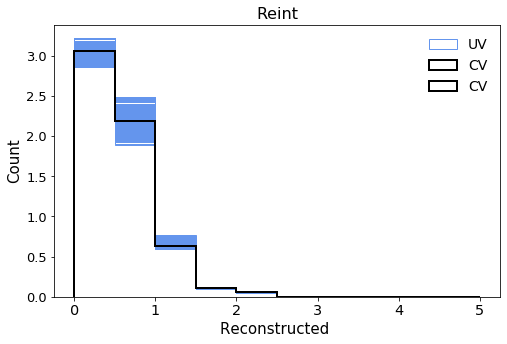

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


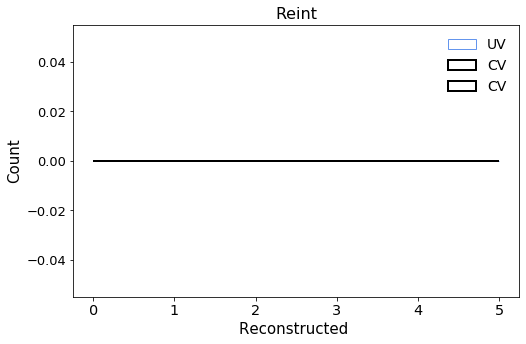

In [35]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [36]:
#will need to edit this if batching

nue_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [45]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_reint.append(sum(masterlist[a]))

final_ncvs_nue_mc_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [46]:

np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""

#################
###angleDiff#####
#################

np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDif_usingSelectionf.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

"""
#################
###leptonMom#####
#################

np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################\n###leptonMom#####\n#################\n\nnp.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_mc_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_mc_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_vars.to_csv(\'nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_splines.to_csv(\'nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [48]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#batch_size = 20000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729
n_events/2 here =  457364.0
1.0
2
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and s

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
dict_keys(['CV', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
[3.060251   2.189677   0.62954187 0.11053944 0.05357313 0.
 0.         0.         0.         0.        ]


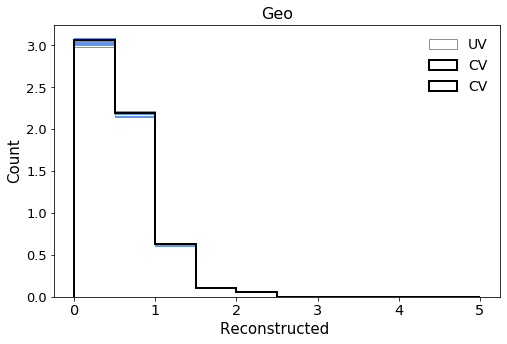

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
dict_keys(['CV'])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


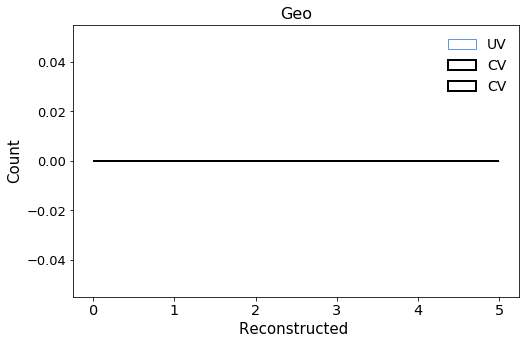

In [49]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 
    print(detvar_dicts[j].keys())


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [50]:
#will need to edit this if batching

nue_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [48]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_geo.append(sum(masterlist[a]))

final_ncvs_nue_mc_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_mc_geo)):
    final_ns_nue_mc_geo[x] = np.concatenate((final_ns_nue_mc_geo[x][0], final_ns_nue_mc_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [49]:

np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#####################
###angleDiff########
####################

np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom########
####################

np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom########\n####################\n\nnp.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#######################################################\n\ntotal_geo_df.to_csv(\'nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_vars.to_csv(\'nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_splines.to_csv(\'nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv\')\n'

## NUE_DIRT SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
DRT  = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)

['selected', 'trk_score_v', 'shr_tkfit_dedx_U', 'shr_distance', 'n_tracks_contained', 'tksh_angle', 'shr_score', 'shr_tkfit_dedx_Y', 'n_showers_contained', 'nu_pdg', 'shr_energy_cali', 'hits_ratio', 'slnhits', 'reco_nu_vtx_sce_y', 'n_showers', 'trkshrhitdist2', 'shr_energy', 'CosmicIPAll3D', 'flash_time', 'shr_px', 'shr_pz', 'shrsubclusters2', 'category', 'shr_phi', 'ccnc', 'shr_py', 'run', 'shrsubclusters1', 'slnunhits', 'nslice', 'n_tracks', 'evt', 'shr_tkfit_npoints', 'trk_energy_tot', 'shr_theta', 'npion', 'nproton', 'shr_tkfit_nhits_V', 'shr_tkfit_nhits_U', 'trk_energy', 'sub', 'reco_nu_vtx_sce_z', 'shrsubclusters0', 'shr_tkfit_nhits_Y', 'tksh_distance', 'shr_tkfit_dedx_V', 'reco_nu_vtx_sce_x', 'shrmoliereavg', 'shr_energy_tot_cali', 'topological_score', 'contained_fraction']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

beamon_pot = 2.0E20 #v5
dirt_pot =  1.42143e+21
scalingDRT = 0.65 #0.35

nue_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [8]:
nue_dirt['totweight_data'] = nue_dirt['pot_scale']*nue_dirt['weightSplineTimesTuneTimesPPFX']

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [11]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  76.19407987594604


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [15]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
  

In [16]:
# add back the cosmic category, for background only
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [17]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [18]:
#Define signal catagories

#nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [18]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(569506, 104)


In [22]:
datasets_bdt = nue_dirt

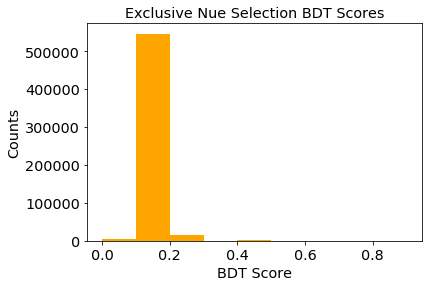

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [24]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

#NUE_SIMPLE_QUERY = 'nslice==1'
#NUE_SIMPLE_QUERY += ' and ' + reco_in_fv_query
#NUE_SIMPLE_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [25]:
test = np.nansum(nue_dirt.query(SIGNAL_NUE_SEL_QUERY )['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_dirt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 0.05574139301588843


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
TEST
1
2
3
current_total  0.05574139301588843
0.055741393015888429651738533721072599291801452636718750000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.05574139301588843
0.055741393015888429651738533721072599291801452636718750000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.

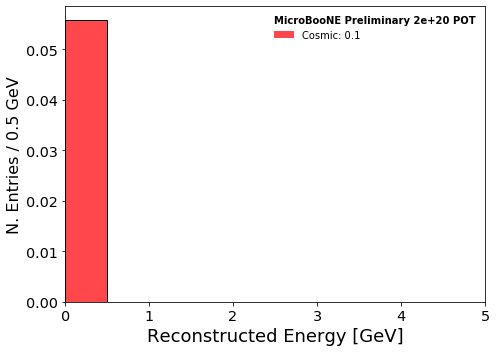

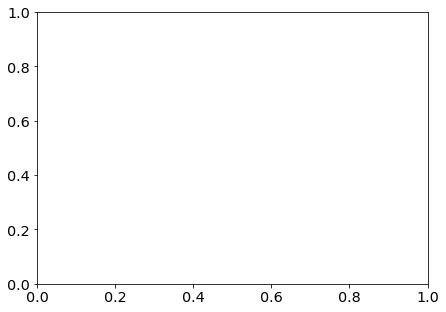

In [27]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # This is the POT scaling factor for dirt sample
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65

    # NU
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


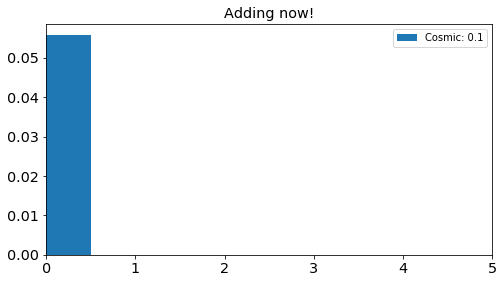

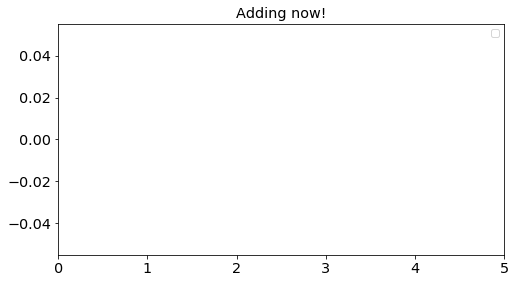

In [28]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [29]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

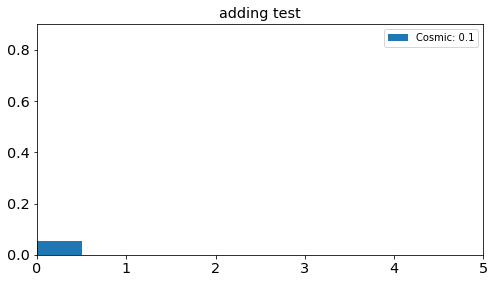

In [30]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 0.9])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.05])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [31]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [32]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Err

In [33]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

LOOK HERE FOR DETSYS
None
err nue dirt: 
[0.00836442 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Returning
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco

In [34]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.008364418428624494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

total selected =  [0.05574139207601547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [35]:

np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')




#########################
#####angleDiff###########
##########################
"""
np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_allselected_corrected.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_allselected_corrected.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####leptonMom###########
##########################
"""
np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\nnp.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_dirt_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_dirt_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errs

In [57]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
    0    1    2    3    4     5    6    7     8     9    ...   590   591  \
0  1042    1   97  666   38  3291  573   78  1043  1146  ...  1000  1000   

    592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 600 columns]
Returning
--------------------------

{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_n

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


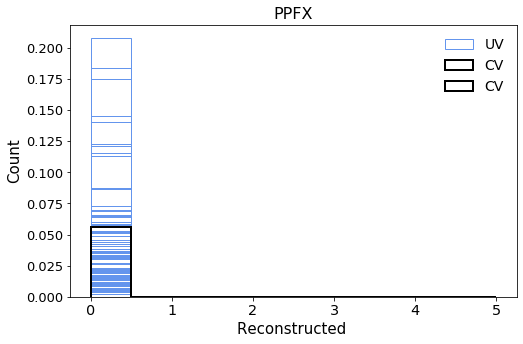

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


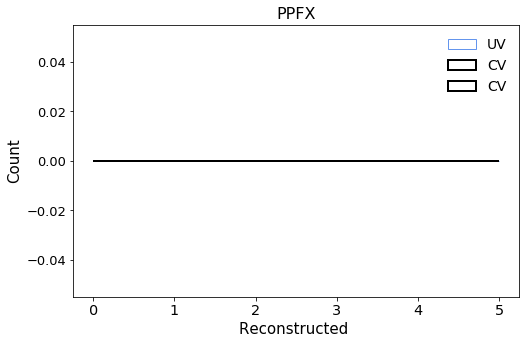

In [58]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [59]:
#will need to edit this if batching

nue_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [37]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [38]:

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')


"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
""" 
#################################
#####leptonMom##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

' \n#################################\n#####leptonMom##################\n############################\n\nnp.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_

In [41]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
PRINT
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & r

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


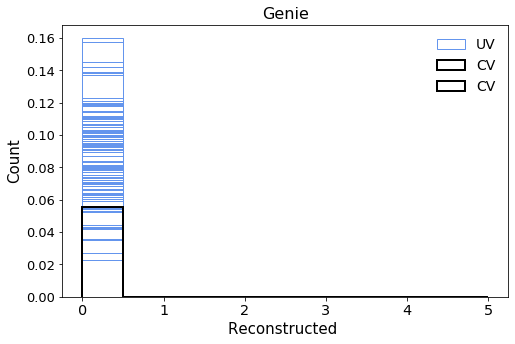

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


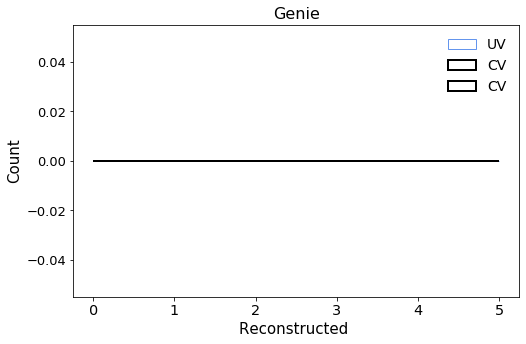

In [61]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [62]:
#will need to edit this if batching

nue_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [40]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_genie.append(sum(masterlist[a]))

final_ncvs_nue_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


    0    1     2    3    4     5    6    7    8    9    ...   590   591   592  \
0  1584  387  1214  646  390  1520  951  722  592  826  ...  1000  1000  1000   

    593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 600 columns]
entry
534379    0.256213
Name: reco_e, dtype: float32
entry
534379    0.091457
Name: weightSpline, dtype: float32


In [41]:

np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#####################
###AngleDiff###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom###\n######################\nnp.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_vars.to_csv(\'nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_splines.to_csv(\'nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [44]:
########### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
weightsReint
1.0
1
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0.04 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
PRINT
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& 

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


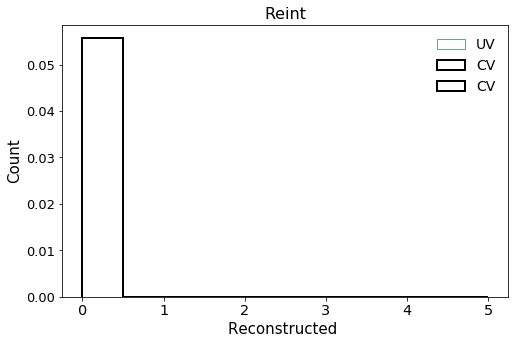

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


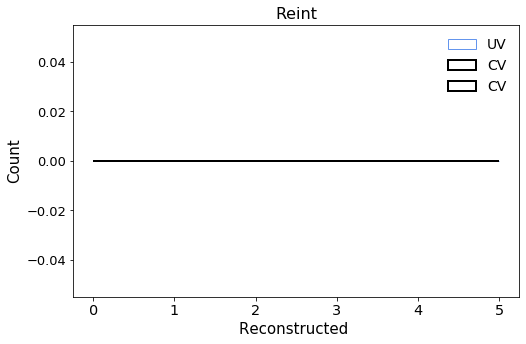

In [45]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [46]:
#will need to edit this if batching

nue_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [47]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_reint.append(sum(masterlist[a]))

final_ncvs_nue_dirt_reint = sum(n_cv_tots)
print(final_ncvs_nue_dirt_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)


[0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
    0     1     2     3     4     5     6     7     8     9    ...   990  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    991   992   993   994   995   996   997   998   999  
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 1000 columns]
entry
534379    0.256213
Name: reco_e, dtype: float32
entry
534379    0.055741
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [48]:

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')


"""
#################
###angleDiff#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#################
###leptonMom#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################\n###leptonMom#####\n#################\n\nnp.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_vars.to_csv(\'nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_splines.to_csv(\'nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [66]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query = truthsel_nue,
        currentsample = "nue_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
1.0
2
{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.09145719451538241}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tks

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.05574139 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


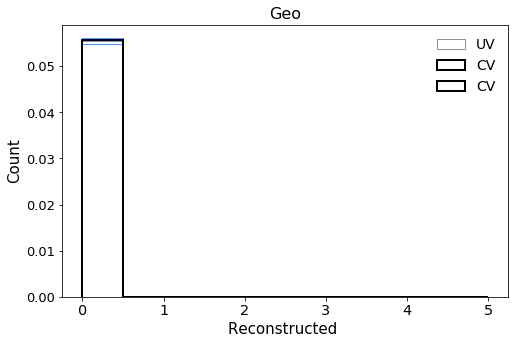

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


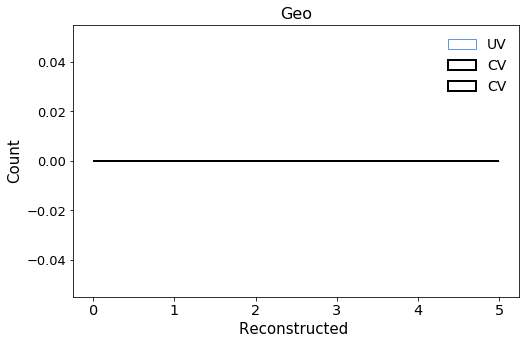

In [69]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [70]:
#will need to edit this if batching

nue_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [31]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_geo.append(sum(masterlist[a]))

final_ncvs_nue_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_dirt_geo)):
    final_ns_nue_dirt_geo[x] = np.concatenate((final_ns_nue_dirt_geo[x][0], final_ns_nue_dirt_geo[x][1]))
    
    
print(final_ns_nue_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[0.05566151 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05582556 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
entry
534379    0.055741
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [47]:

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

"""
#####################
###angleDiff########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelectionf.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelectionf.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom########\n####################\n\nnp.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#######################################################\n\ntotal_geo_df.to_csv(\'nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_vars.to_csv(\'nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_splines.to_csv(\'nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv\')\n'

## NUE_EXT SAMPLE

In [6]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND

#actually fetch datasets
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_ext]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_ext  = nue_ext.pandas.df(nue_variables + nue_varMC, flatten=False)

['shr_phi', 'shr_tkfit_dedx_U', 'shr_energy', 'nu_pdg', 'shrsubclusters1', 'trk_score_v', 'flash_time', 'n_tracks', 'n_showers_contained', 'slnunhits', 'tksh_distance', 'reco_nu_vtx_sce_z', 'shr_energy_cali', 'shr_tkfit_npoints', 'ccnc', 'shrsubclusters2', 'nproton', 'CosmicIPAll3D', 'shr_tkfit_nhits_U', 'reco_nu_vtx_sce_x', 'topological_score', 'n_tracks_contained', 'reco_nu_vtx_sce_y', 'shr_tkfit_nhits_Y', 'n_showers', 'shr_energy_tot_cali', 'category', 'selected', 'npion', 'shr_score', 'shr_py', 'trk_energy_tot', 'slnhits', 'sub', 'shr_pz', 'shrmoliereavg', 'evt', 'shr_tkfit_dedx_Y', 'shrsubclusters0', 'shr_px', 'shr_tkfit_nhits_V', 'run', 'hits_ratio', 'shr_distance', 'contained_fraction', 'trkshrhitdist2', 'shr_theta', 'trk_energy', 'nslice', 'tksh_angle', 'shr_tkfit_dedx_V']


In [7]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98

nue_ext['pot_scale'] = extratio * scalingEXT

In [8]:
nue_ext['totweight_data'] = nue_ext['pot_scale']

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [101]:
#This assumes the electron to be the leading shower
df_v = [nue_ext]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [125]:
for i,df in enumerate(df_v):
    print(df['shr_px']) 

entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
904357    0.0
904358    0.0
904359    0.0
904360    0.0
904361    0.0
Name: shr_px, Length: 904362, dtype: float32


In [11]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_ext]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  84.49643564224243


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_ext]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])

In [15]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
    

In [16]:
# add back the cosmic category, for background only
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [17]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT 

In [18]:
#Define signal catagories

nue_ext["is_signal"] = nue_ext["category"] == 11

Set up complete. Set up BDT for selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_ext]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(904362, 91)


In [22]:
datasets_bdt = nue_ext

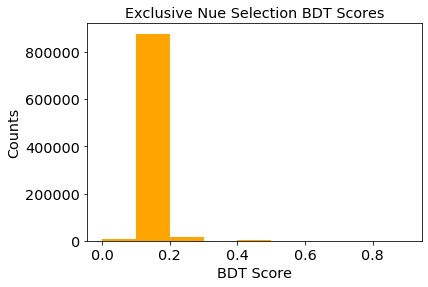

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [24]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

#NUE_SIMPLE_QUERY = 'nslice==1'
#NUE_SIMPLE_QUERY += ' and ' + reco_in_fv_query
#NUE_SIMPLE_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [25]:
test = np.nansum(nue_ext.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_ext.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 0.5612087579382191


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  904362
n_events/2 here =  452181.0

1.0
1
{'ext': 0.5612087579382191}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 0.5612087579382191
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000

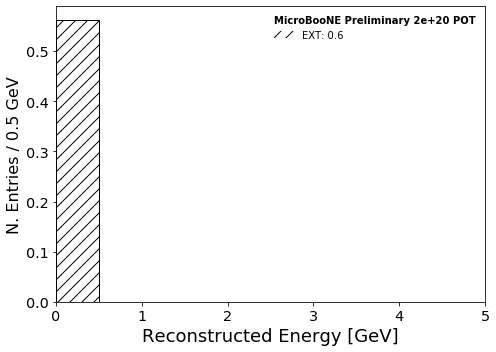

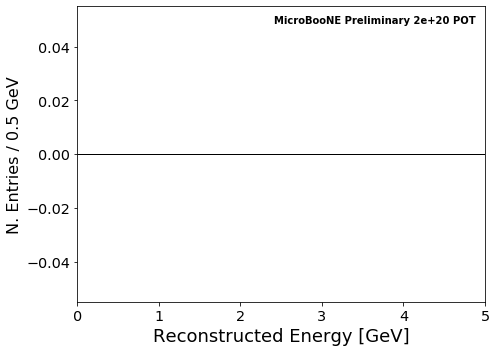

In [26]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
#batch_size = n_events
batch_size = n_events
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
    

    # NU
    weights = { #full sample mc = 0.38  
                "ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


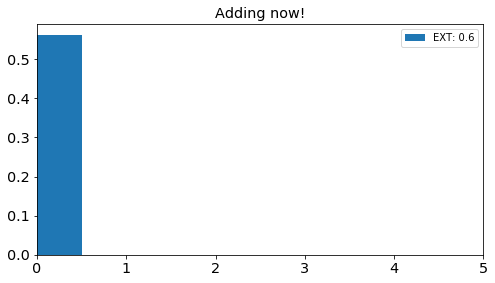

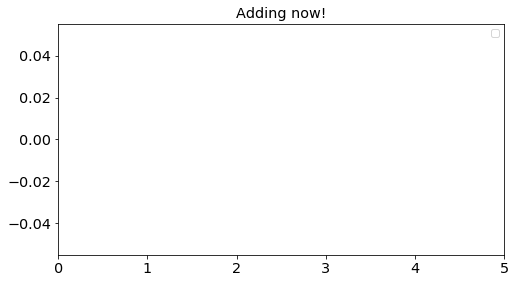

In [27]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [28]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

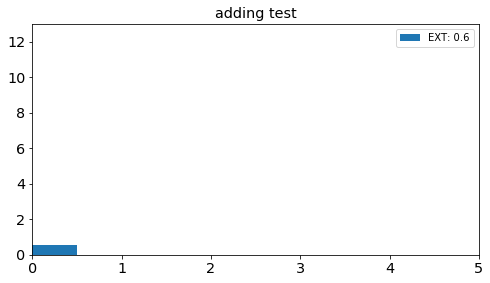

In [29]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 13])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.8])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [30]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [74]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV.csv')
#weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV.csv')

### Stat Errs

In [79]:
"""
#This is the stat errors on the selected ext

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }

    
    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
    

    
    weights = { #full sample mc = 0.38  
                "nue_ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    
    
#can just use the values from above thr current_selected values
"""

n_events here =  904362
n_events/2 here =  452181.0

1.0
1
{'nue_ext': 0.5612087579382191}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_ext

LOOK HERE FOR DETSYS
None
err nue ext: 
[0.31495527 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
detsys nue ext: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Returning
{'nue_ext': 0.5612087579382191}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_conta

In [81]:
"""
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_ext_stat_errs = total_errs
"""

total errs =  [0.3149552699865586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



[0.74913868 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


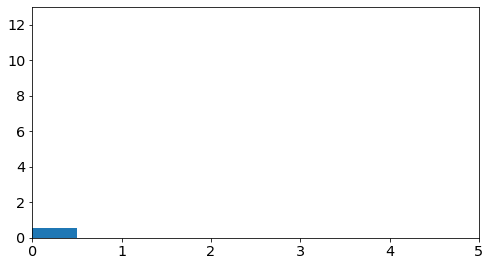

In [33]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 13])


nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


nue_ext_stat_errs = np.sqrt(nue_stacked[0])

print(nue_ext_stat_errs)

In [34]:

np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           nue_ext_stat_errs,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_ext_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
#           nue_ext_stat_errs_selected,
#           delimiter =", ", 
#           fmt ='% s')


"""
#########################
#####angleDiff###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

## NUE_DATA SAMPLE

In [83]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND

#actually fetch datasets
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_data]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_data = nue_data.pandas.df(nue_variables + nue_varMC , flatten=False)

['trk_score_v', 'shr_pz', 'shr_py', 'category', 'shr_energy', 'nu_pdg', 'trk_energy', 'reco_nu_vtx_sce_y', 'nproton', 'selected', 'npion', 'shrsubclusters0', 'tksh_distance', 'slnhits', 'shr_energy_tot_cali', 'CosmicIPAll3D', 'trk_energy_tot', 'shr_tkfit_dedx_U', 'n_showers', 'shr_score', 'reco_nu_vtx_sce_z', 'contained_fraction', 'n_tracks_contained', 'shr_tkfit_dedx_Y', 'shr_energy_cali', 'shr_distance', 'shr_tkfit_nhits_Y', 'shrmoliereavg', 'shr_tkfit_dedx_V', 'shr_phi', 'run', 'n_showers_contained', 'topological_score', 'hits_ratio', 'evt', 'shrsubclusters1', 'nslice', 'shrsubclusters2', 'flash_time', 'shr_tkfit_nhits_U', 'trkshrhitdist2', 'reco_nu_vtx_sce_x', 'n_tracks', 'tksh_angle', 'shr_theta', 'sub', 'shr_tkfit_npoints', 'slnunhits', 'shr_px', 'shr_tkfit_nhits_V', 'ccnc']


In [84]:
nue_data['pot_scale'] = [1 for x in range(len(nue_data))]

In [85]:
nue_data['totweight_data'] = nue_data['pot_scale']

In [86]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [87]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [161]:
#This assumes the electron to be the leading shower
df_v = [nue_data]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [88]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_data]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  47.228351354599


In [89]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [90]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [91]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_data]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])


In [92]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)


In [93]:
test = np.nansum(nue_data.query("is_signal==True")['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0


In [94]:
# add back the cosmic category, for background only
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [95]:
#Define signal catagories

nue_data["is_signal"] = nue_data["category"] == 11

Set up complete. Now on to BDT.

In [96]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [97]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [98]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(610496, 91)


In [99]:
datasets_bdt = nue_data

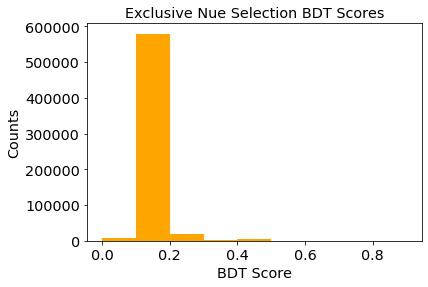

In [100]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [101]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

#NUE_SIMPLE_QUERY = 'nslice==1'
#NUE_SIMPLE_QUERY += ' and ' + reco_in_fv_query
#NUE_SIMPLE_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [102]:
test = np.nansum(nue_data.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_data.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0
total signal events = 61


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  610496
n_events/2 here =  305248.0

1.0
1
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split 

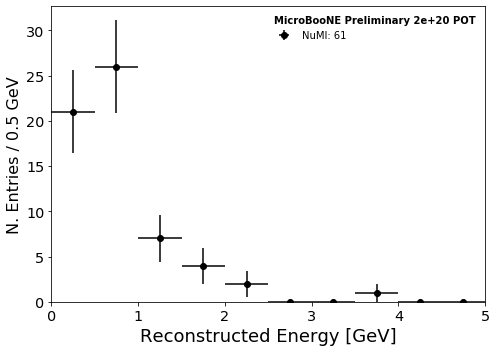

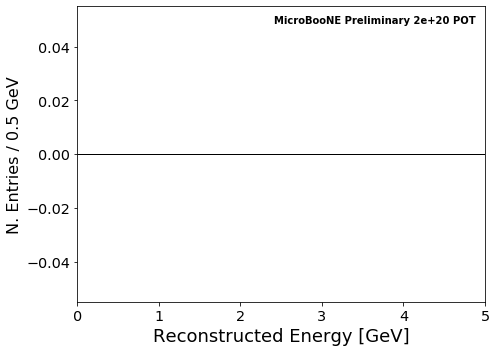

In [103]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_data.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_data.iloc[start:end]

    samples = {
        "nue_data": sample_set 
    }

    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "nue_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

[array([21, 26,  7,  4,  2,  0,  0,  1,  0,  0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


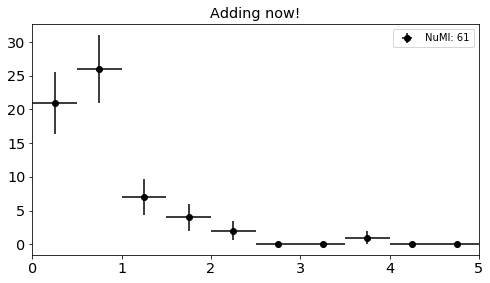

In [104]:
from matplotlib import gridspec

#for i in range(int(n_events/batch_size)+1):
for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [105]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[4.58257569 5.09901951 2.64575131 2.         1.41421356 0.
 0.         1.         0.         0.        ]


[21 26  7  4  2  0  0  1  0  0]


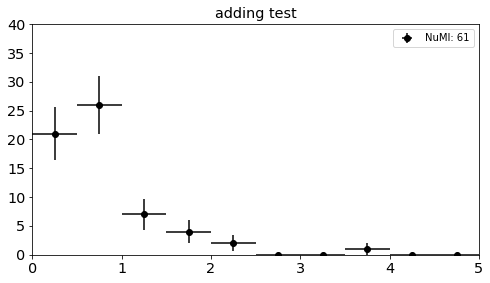

In [106]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 33])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [107]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

## NUMU_MC SAMPLE (and Nue)

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

#actually fetch datasets
numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['nu_pdg', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'trk_mcs_muon_mom_v', 'CosmicIPAll3D', 'flash_pe', 'slnunhits', 'evnunhits', 'muon_e', 'reco_e', 'trk_energy_muon', 'reco_nu_vtx_sce_z', 'nmuon', 'slnhits', 'trk_sce_start_x_v', '_opfilter_pe_veto', 'npi0', 'pion_e', 'trk_theta', 'nslice', 'reco_nu_vtx_y', 'trk_range_muon_mom_v', 'trk_sce_end_z_v', 'evt', 'category', 'slpdg', 'true_e_visible', 'reco_nu_vtx_sce_x', 'trk_phi', 'CosmicDirAll3D', 'ccnc', 'run', 'reco_nu_vtx_sce_y', 'nproton', 'interaction', 'slclustfrac', '_opfilter_pe_beam', 'sub', 'trk_llr_pid_score_v', 'CosmicIP', 'shr_energy_tot_cali', 'topological_score', 'reco_nu_vtx_x', 'reco_nu_vtx_z', 'isVtxInFiducial', 'trk_energy_tot', 'mc_pdg', 'npion', 'backtracked_pdg', 'pi0truth_elec_etot', 'pi0_e']


In [5]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)

trk_llr_pid_v  [[0.73482436] [-0.70503384 0.5525445 -3.4028235e+38] [] ... [] [] [0.9896643 0.5211012 0.04211452]]
trk_score_v  [[0.8417371] [0.9219987 0.9697223 -1.0] [] ... [] [] [1.0 0.011713999 0.47363594]]
Here:
trk_range_muon_mom_v  [[0.2488809] [0.121225685 0.109380074 -3.4028235e+38] [] ... [] [] [1.2258223 0.20158982 0.05128334]]
trk_mcs_muon_mom_v  [[0.27999988] [0.40099838 14.999432 -3.4028235e+38] [] ... [] [] [1.9420298 0.13100009 14.993429]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1543.0856430530548


In [6]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  41361.94411444664


In [8]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']
    #print(df['trk_sce_start_x_v'])
    #print(df['reco_nu_vtx_sce_x'])
    #print(df['nu_pdg'])

In [9]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [10]:
beamon_pot = 2.0E20 #v5
overlay_pot =  2.33652E21

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [11]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['weightSplineTimesTuneTimesPPFX']

In [12]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [13]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [14]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5983/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  16.997814416885376


In [17]:
#numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [15]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [16]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [51]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    print(df['trk_mcs_muon_mom_v'])

entry
0                                    [0.27999988]
1         [0.40099838, 14.999432, -3.4028235e+38]
2                                              []
3                                    [0.26700005]
4                                              []
                           ...                   
914724                                         []
914725                    [0.31199953, 14.999432]
914726                                         []
914727                                         []
914728         [1.9420298, 0.13100009, 14.993429]
Name: trk_mcs_muon_mom_v, Length: 914729, dtype: object


In [17]:
numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [18]:
"""
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
"""
df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    print(df['muon_momentum'])

#if track is stopped in fiducial volume
#    then use stoppingmom
#else
#    use other mom
    
#set up this new variable for each one in  the dataframe

#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
61        0.411006
214       0.400905
278       0.264861
341       0.178695
342       0.527353
            ...   
914563    0.208389
914600     1.44101
914616    0.375773
914619    0.718173
914652    0.875998
Name: muon_mom, Length: 24675, dtype: object


In [19]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [17]:
numu_mc   = numu_mc.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete. 

In [18]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "numu_mc"  : numu_mc,
    "numu_nue" : numu_nue
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
#nueratio  = pot/2.37838e+22

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling,
            "numu_nue"  : mcratio  * SPLIT * scaling   
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.08559738414394057, 'numu_nue': 0.08559738414394057}


In [19]:
for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
   

In [20]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

Now plot.

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
TEST
1
2
3
current_total  1861.6178496178882
1861.617849617888168722856789827346801757812500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1861.6178496178882
1861.617849617888168722856789827346801757812500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  1861.6178496178882
1861.617849617888168722856789827346801757812500000

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
Had to return early (colour sorting).


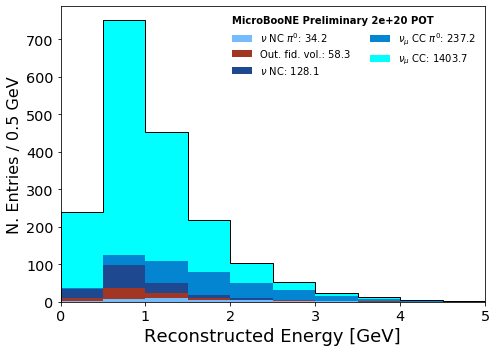

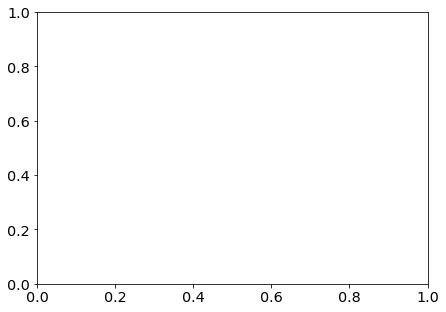

In [21]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    # NUMU
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',10,(0.0, 10.0),"Particle Tests"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
TEST
1
2
3
current_total  939.163851220961
939.163851220960964383266400545835494995117187500000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  939.163851220961
939.163851220960964383266400545835494995117187500000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  939.163851220961
939.16385122096096438326640054583549499

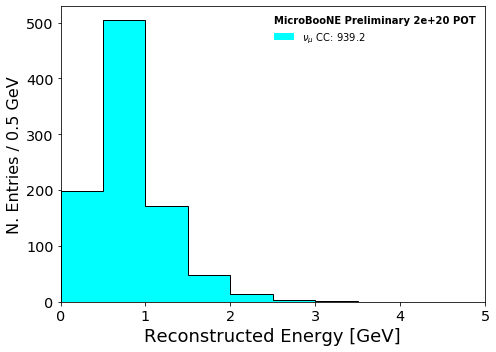

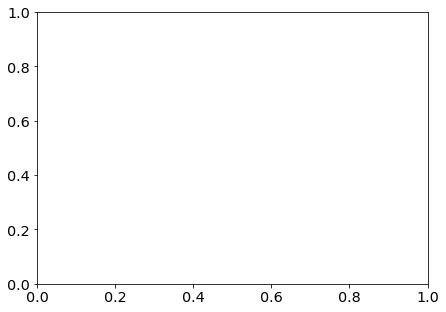

In [28]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',10,(0.0, 10.0),"Particle Tests"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


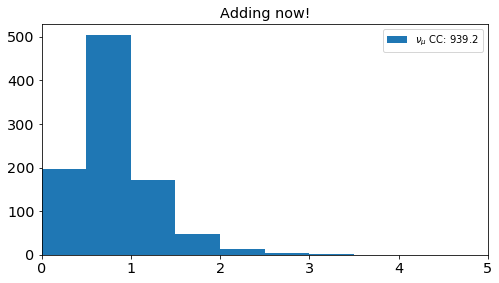

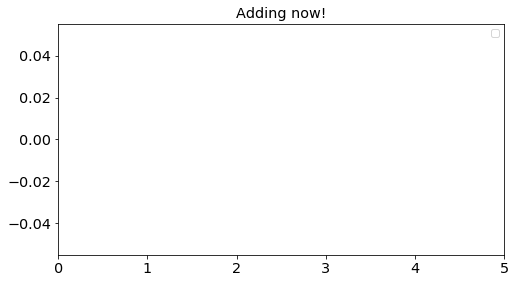

In [29]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [30]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

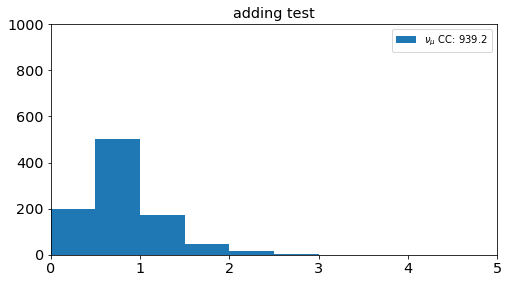

In [31]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [32]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3  #3

#numu_wanted_list = numu_stacked[0]
numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [33]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

if (is_selected == True):
    ######full trueE
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
    #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
    vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv')
    weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif (is_selected == False):
    ######full trueE
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
    vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_07Jul.csv')
    weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_07Jul.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


n_events here =  12646

1.0
1
{'numu_nue': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
----

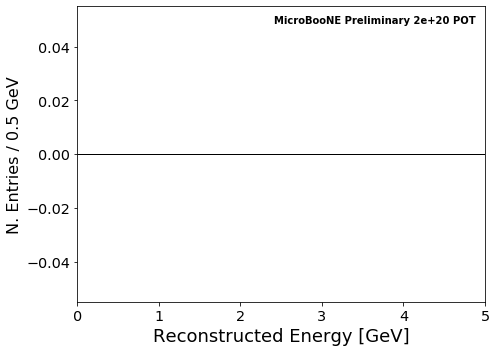

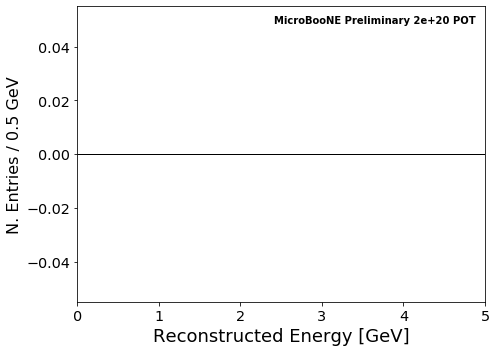

In [34]:
#The numu_nue plot (should be empty)

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []
if n_events > 0:
    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = numu_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "numu_nue": sample_set 
        }


        scaling = 1
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33652e+21

        # NUE
        weights = { #full sample mc = 0.38
                    "numu_nue"  : mcratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
        #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
        #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"


        var, weight, label = my_plotter.plot_variable(
            VARIABLE,
            query= NUMU_SEL_QUERY,
            currentsample = "numu_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss.append(var)
        weightss.append(weight)
        labss.append(label)

### Stat Errors

In [35]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[1.56209768e+01 3.96679025e+01 1.32543841e+01 3.65612917e+00
 1.16497904e+00 3.37037960e-01 8.79229461e-02 2.93076487e-02
 7.32691217e-03 7.32691217e-03]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1.97757233e+02 5.03877106e+02 1.71203629e+02 4.71697655e+01
 1.43198395e+01 3.47640562e+00 8.27352941e-01 3.03658009e-01
 1.01967163e-01 1.26867741e-01]
Returning
{'numu_mc': 0.085

In [36]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [15.62097675131232, 39.66790250075276, 13.25438411966416, 3.6561291739703785, 1.1649790353933671, 0.3370379599251251, 0.08792294606742393, 0.029307648689141312, 0.007326912172285328, 0.007326912172285328]
total selected =  [197.75723266601562, 503.8771057128906, 171.20362854003906, 47.16976547241211, 14.319839477539062, 3.476405620574951, 0.8273529410362244, 0.30365800857543945, 0.10196716338396072, 0.12686774134635925]


In [37]:

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')



#########################
#####angleDiff###########
##########################
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_mc_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_mc_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

In [38]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5and is_signal==False& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[ 5.03358866 24.02494501 24.86753991 15.26928497  7.5833541   4.00782096
  1.83905496  1.05507535  0.45426855  0.28574957]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 56.127445  267.2475    269.2825    165.6764     83.69907    44.113907
  20.156286   11.383905    5.034206    3.0953765]
Returning
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _

In [39]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [5.03358866236002, 24.024945012923588, 24.8675399127364, 15.269284967042623, 7.583354098315314, 4.007820958240075, 1.8390549552436173, 1.0550753528090873, 0.4542685546816903, 0.2857495747191278]
total selected =  [56.127445220947266, 267.24749755859375, 269.2825012207031, 165.67640686035156, 83.6990737915039, 44.11390686035156, 20.156286239624023, 11.383905410766602, 5.034205913543701, 3.095376491546631]


In [40]:

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_07Jul.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_07Jul.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')



#########################
#####angleDiff###########
##########################
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_mc_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_mc_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors

In [21]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1308   496  1938   760  1833  1414   881  1704  1812  1575  ...  1260   
1       741   844   665   925   406   522   588   611   457   563  ...   483   
2       500  1080   438   246  1169   385   553   537   444   372  ...   469   
3       402  2818  1874  1255   361    32   343   672   804    71  ...  1976   
4      1969  1915   870  1902  2379  1852   701  130

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[255.40151978 777.87927246 445.50341797 216.8560791  100.91320801
  48.92480469  21.82995605  12.02770996   5.75634766   3.26538086]


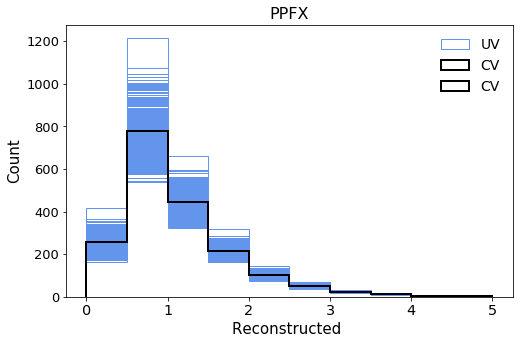

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


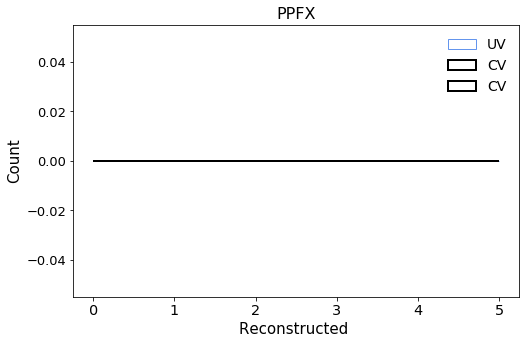

In [22]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [23]:
#will need to edit this if batching

numu_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [60]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [61]:
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

"""
###############################
######angleDiff##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
###############################
######leptonMom##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n###############################\n######leptonMom##########\n######################\n\nnp.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_numu_mc_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_numu_mc_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [24]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1351  1050   861  1276  1085  1398  1144  1169  1298  1306  ...  1362   
1       881   529   659  1166   598   457  1029   585  1626   446  ...   832   
2       630   853   390  1343     1  1058  1340  1192   670  1329  ...  1007   
3      1243  1130  1114  1196  1146  1237  1162  1128  1195  1234  ...  1244   
4      1087   267   331   714   326  1598   966   99

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[255.40151978 777.87927246 445.50341797 216.8560791  100.91320801
  48.92480469  21.82995605  12.02770996   5.75634766   3.26538086]


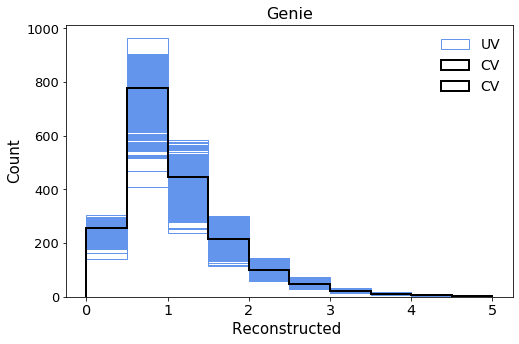

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


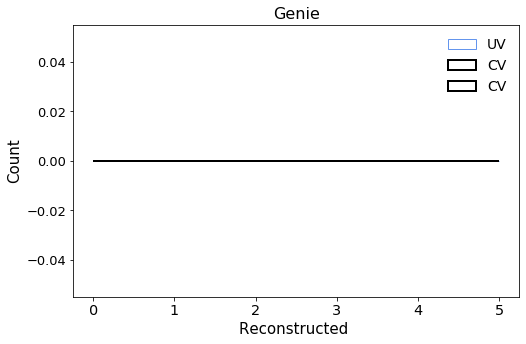

In [25]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [26]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [63]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [64]:
np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

"""
###########################
#####angleDiff###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
###########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n###########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_numu_mc_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_numu_mc_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_vars.to_csv(\'numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_splines.to_csv(\'numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [27]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   990  \
0      1104  1302   736   987  1141  1068  1118  1085   859  1056  ...  1186   
1      1094  1318   680   996  1091  1087  1246  1092   888  1024  ...  1276   
2       970   915  1045  1004   952   985   983   978  1039   979  ...   961   
3       978   936  1040  1002   968   987   980   983  1027   986  ...   965   
4       980   940  1039  1002   970   988   979   98

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[255.40151978 777.87927246 445.50341797 216.8560791  100.91320801
  48.92480469  21.82995605  12.02770996   5.75634766   3.26538086]


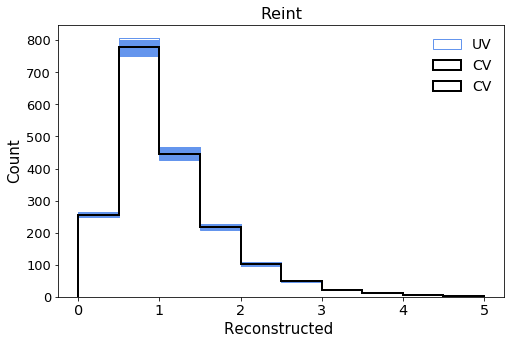

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


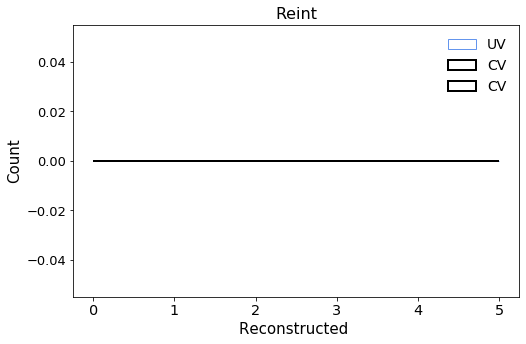

In [28]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [29]:
#will need to edit this if batching

numu_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [66]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [67]:
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')


#############################
#####angleDiff##########
#######################
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

#############################
#####leptonMom##########
#######################
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\nnp.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_numu_mc_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_numu_mc_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_vars.to_csv(\'numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_splines.to_csv(\'numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [30]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  914729
1.0
2
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 an

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[255.40151978 777.87927246 445.50341797 216.8560791  100.91320801
  48.92480469  21.82995605  12.02770996   5.75634766   3.26538086]


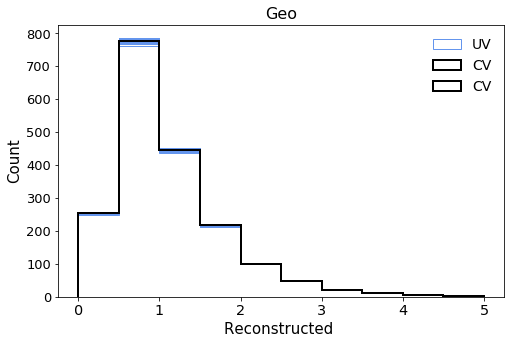

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


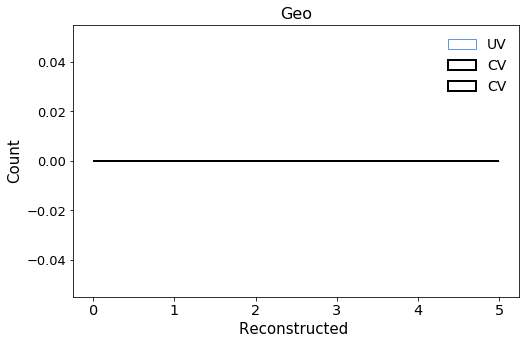

In [31]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [32]:
#will need to edit this if batching

numu_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [69]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [70]:
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

########################
####angleDiff##########
#######################
"""

np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
########################
####leptonMom##########
#######################


np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n########################\n####leptonMom##########\n#######################\n\n\nnp.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_numu_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_numu_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_geo_df.to_csv(\'numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_vars.to_csv(\'numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_splines.to_csv(\'numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv\')\n'

## NUMU_DIRT SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

#actually fetch datasets
numu_dirt  = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_dirt]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali",
        "reco_e", "trk_energy_tot", 
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['evt', 'trk_llr_pid_score_v', 'slpdg', 'slnhits', 'reco_nu_vtx_sce_x', 'trk_sce_end_x_v', 'pi0_e', 'pi0truth_elec_etot', 'npion', 'CosmicIPAll3D', 'trk_sce_end_z_v', 'ccnc', 'sub', 'true_e_visible', 'reco_nu_vtx_z', 'reco_nu_vtx_sce_y', '_opfilter_pe_veto', 'slnunhits', 'isVtxInFiducial', 'trk_sce_end_y_v', 'reco_nu_vtx_x', 'trk_range_muon_mom_v', 'trk_phi', 'nu_pdg', 'flash_pe', 'CosmicDirAll3D', 'nmuon', 'reco_nu_vtx_sce_z', 'backtracked_pdg', 'reco_nu_vtx_y', 'CosmicIP', 'run', 'topological_score', 'trk_theta', 'npi0', 'trk_energy_muon', 'reco_e', 'nslice', 'category', '_opfilter_pe_beam', 'trk_mcs_muon_mom_v', 'pion_e', 'evnunhits', 'trk_sce_start_x_v', 'interaction', 'mc_pdg', 'shr_energy_tot_cali', 'nproton', 'slclustfrac', 'trk_energy_tot', 'muon_e']


In [5]:
import time
s = time.time()

import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS + PPFX

# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 



for ii, CV in enumerate(uproot_v):
    print("1")
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print()
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        print("4")
        numu_dirt =  CVDF

s2 = time.time()

print("runtime = ", s2-s)

1

2
trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


3
4
runtime =  261.9931926727295


In [6]:
df_v = [numu_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
s = time.time()

df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  15853.244863986969


In [8]:
beamon_pot = 2.0E20 #v5
dirt_pot =  1.42143e+21
scalingDRT = 0.35

numu_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [9]:
numu_dirt['totweight_data'] = numu_dirt['pot_scale']*numu_dirt['weightSplineTimesTuneTimesPPFX']

In [10]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [11]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [12]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [13]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5898/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  10.507619142532349


In [14]:
#numu_dirt["is_signal"]   = numu_dirt["category"] == 2
#print(numu_mc["is_signal"])

In [14]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [15]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [15]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    print(df["n_muons_tot"])

entry
0         0
1         0
2         0
3         0
4         0
         ..
569501    0
569502    0
569503    0
569504    0
569505    0
Name: n_muons_tot, Length: 569506, dtype: int64


In [16]:
numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [17]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
1138      0.241054
1205      0.472777
3527      0.317174
4255      0.392615
5356      0.921958
            ...   
566111    0.549741
566137    0.222463
566221    0.395383
567666     1.10804
569370       1.053
Name: muon_mom, Length: 408, dtype: object


In [18]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])
    print(df['cosNu_Angle_Numi_Muon'])
    print(df['reco_nu_vtx_sce_x'])

entry
1138     -0.766328
1205      0.794024
3527      0.341467
4255     -0.800791
5356      0.974622
            ...   
566111    0.735774
566137    0.637509
566221   -0.866412
567666   -0.386616
569370    0.974186
Name: cosNu_Angle_Numi_Muon, Length: 408, dtype: float64
entry
1138       13.671485
1205      112.259079
3527      226.951233
4255      110.254593
5356        6.271605
             ...    
566111    108.329697
566137     82.859444
566221     98.982269
567666     20.502098
569370      5.779076
Name: reco_nu_vtx_sce_x, Length: 408, dtype: float32


In [16]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
  

In [17]:
numu_dirt   = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete.

In [18]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_dirt"  : numu_dirt
}

pot       =  2e+20
dirtratio = pot/1.42143e+21

SPLIT = 1.0
scaling = 1
scalingDRT = 0.65 #0.35

weights = {  "numu_dirt": dirtratio* SPLIT * scalingDRT,  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_dirt': 0.09145719451538241}


In [19]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

n_events here =  569506

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
TEST
1
2
3
current_total  30.70021864859599
30.700218648595988923943878035061061382293701171875000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  30.70021864859599
30.700218648595988923943878035061061382293701171875000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  30.70021864859599
30.7002186485959889239438

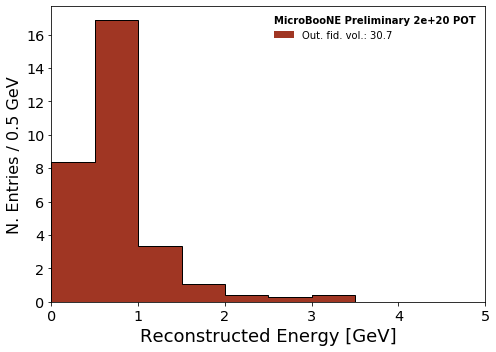

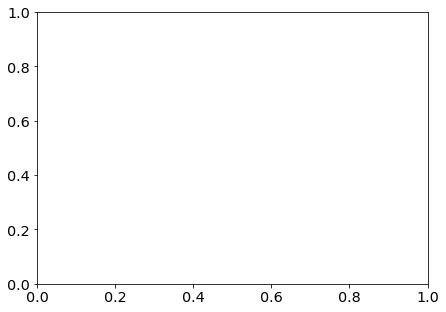

In [59]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.65 #0.35

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


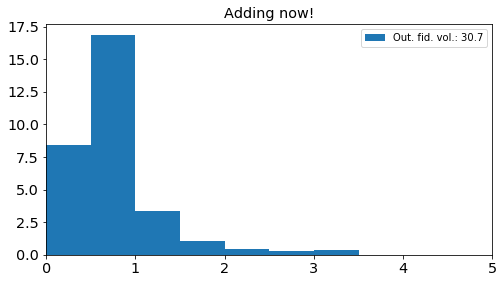

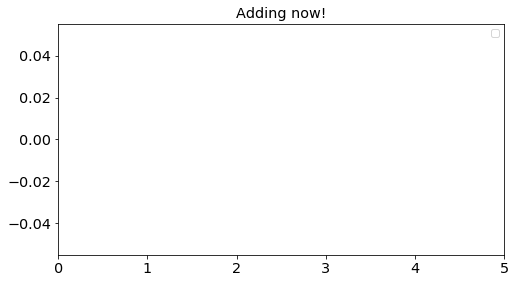

In [60]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [61]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

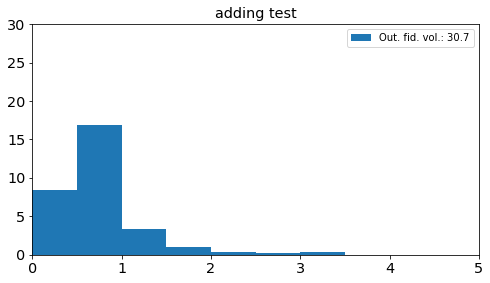

In [62]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 30])

##AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 15])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [63]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [64]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full true
vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Err

In [65]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  569506

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

LOOK HERE FOR DETSYS
None
err numu dirt: 
[0.84480626 1.64779043 0.29275465 0.11710186 0.04182209 0.02509326
 0.03345767 0.         0.         0.        ]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 8.391793   16.843082    3.3388476   1.0566067   0.41089666  0.2715866
  0.38740632  0.          0.          0.        ]
Returning
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 2

In [66]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errs =  [0.8448062612910738, 1.6477904304390252, 0.2927546450018573, 0.11710185800074292, 0.04182209214312247, 0.025093255285873483, 0.033457673714497975, 0.0, 0.0, 0.0]
total selected =  [8.391793251037598, 16.843082427978516, 3.3388476371765137, 1.056606650352478, 0.4108966588973999, 0.2715865969657898, 0.3874063193798065, 0.0, 0.0, 0.0]


In [67]:


np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


#########################
#####angleDiff###########
##########################
"""
np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_dirt_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           numu_dirt_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errs

In [20]:
############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0    1700  1069  1076  1679   919  1187  1286   848  1386  1244  ...  1000   
1    1158  1344   930   939   891   866  1061  1006  1269   879  ...  1000   
2    1251   486  1841   684  1941  1432   836  1602  1770  1552  ...  1000   
3     601  1622  1172  1077   493   170   675   807  1045   243  ...  1000   
4     829  1630  1263   451  144

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.39179325 16.84308243  3.33884811  1.05660629  0.4108963   0.27158737
  0.3874054   0.          0.          0.        ]


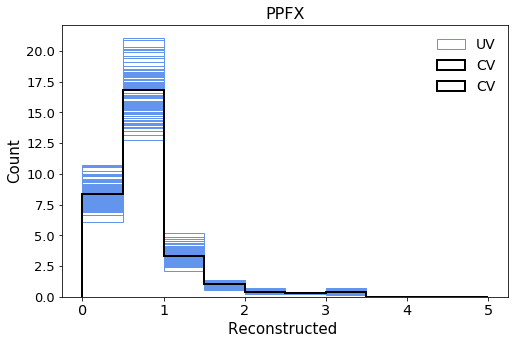

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


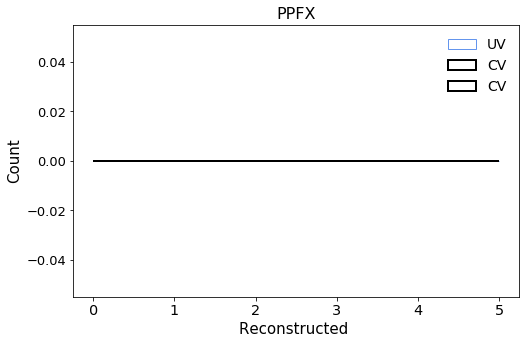

In [21]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [22]:
#will need to edit this if batching

numu_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [69]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_numu_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [70]:

np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')


"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
""" 
#################################
#####leptonMom##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

' \n#################################\n#####leptonMom##################\n############################\n\nnp.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_

In [23]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0     772   594  1004   919  1336   708   955   450   611  1370  ...  1000   
1     616   289  1236   632   700   534  1924   129   827   776  ...  1000   
2    1236  1103  1107   513   744   342   690  1187   291   789  ...  1000   
3    2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
4    1237  1055   912  1197  107

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.39179325 16.84308243  3.33884811  1.05660629  0.4108963   0.27158737
  0.3874054   0.          0.          0.        ]


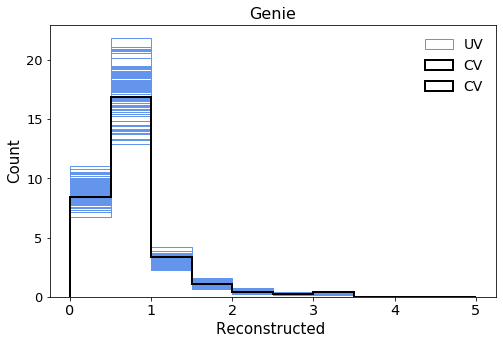

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


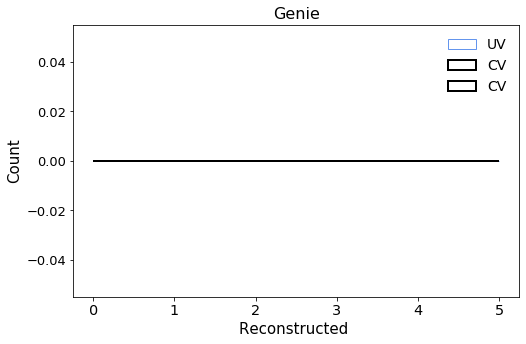

In [24]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [25]:
#will need to edit this if batching

numu_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [72]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_genie.append(sum(masterlist[a]))

final_ncvs_numu_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


      0     1     2     3     4     5     6     7     8     9    ...   590  \
0     772   594  1004   919  1336   708   955   450   611  1370  ...  1000   
1     616   289  1236   632   700   534  1924   129   827   776  ...  1000   
2    1236  1103  1107   513   744   342   690  1187   291   789  ...  1000   
3    2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
4    1237  1055   912  1197  1078  1265  1116  1135  1210  1212  ...  1000   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
354   744  1642  2044  1156  1535   779  1677   450  1188  1173  ...  1000   
355  1201  1060   944  1170  1078  1222  1108  1123  1180  1182  ...  1000   
356  1651  1070   798  1497  1125  1783  1228  1294  1549  1545  ...  1000   
357  1269  1152  1079  1235  1168  1277  1190  1185  1240  1256  ...  1000   
358   744   952   374  1056   452  1148   847  1352   945  1194  ...  1000   

      591   592   593   594   595   596   597   598   599  
0  

In [73]:

np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
"""
#####################
###AngleDiff###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom###\n######################\nnp.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_vars.to_csv(\'nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_genie_df_splines.to_csv(\'nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [20]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query=truthsel_nue,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
weightsReint
1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   990  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
2     999   998  1000  1000   999   999   999   999  1000   999  ...   999   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
4    1000  1000  100

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.39179325 16.84308243  3.33884811  1.05660629  0.4108963   0.27158737
  0.3874054   0.          0.          0.        ]


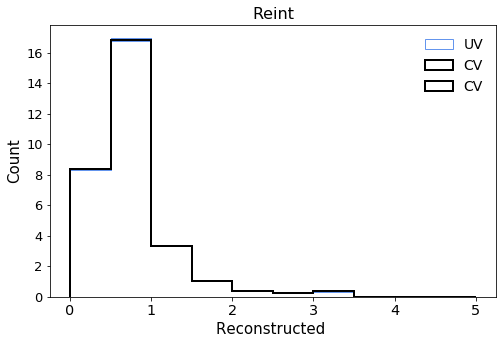

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


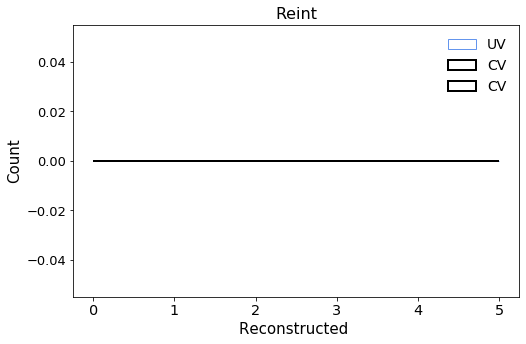

In [21]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [22]:
#will need to edit this if batching

numu_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [23]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_reint.append(sum(masterlist[a]))

final_ncvs_numu_dirt_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [24]:

np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')


"""
#################
###angleDiff#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#################
###leptonMom#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################\n###leptonMom#####\n#################\n\nnp.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_vars.to_csv(\'nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_reint_df_splines.to_csv(\'nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\n'

In [29]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.65
    
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query = truthsel_nue,
        currentsample = "numu_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
1.0
2
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pio

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.39179325 16.84308243  3.33884811  1.05660629  0.4108963   0.27158737
  0.3874054   0.          0.          0.        ]


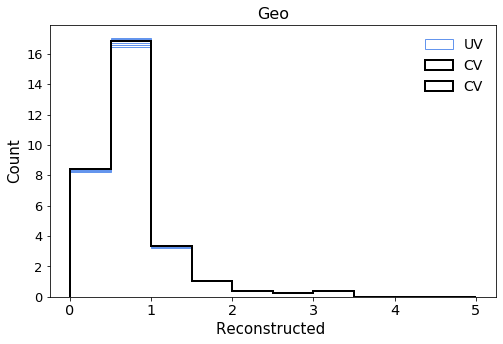

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


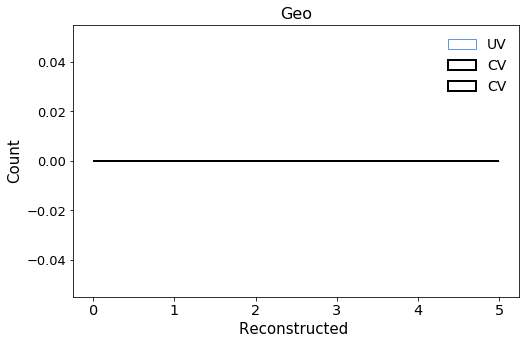

In [30]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [31]:
#will need to edit this if batching

numu_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

In [78]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_geo.append(sum(masterlist[a]))

final_ncvs_numu_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_numu_dirt_geo)):
    final_ns_numu_dirt_geo[x] = np.concatenate((final_ns_numu_dirt_geo[x][0], final_ns_numu_dirt_geo[x][1]))
    
    
print(final_ns_numu_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[ 8.40922499 16.88253789  3.32180982  1.06806415  0.41179866  0.27276054
  0.42984254  0.          0.          0.          8.42687581 16.94504704
  3.33384738  1.07336257  0.41651959  0.2728379   0.41066997  0.
  0.          0.        ]
entry
1138      0.112416
1205      0.093798
3527      0.094258
4255      0.114837
6008      0.076957
            ...   
565983    0.119232
566111    0.111650
566137    0.062956
566221    0.059272
567666    0.107105
Name: weightSplineTimesTuneTimesPPFX, Length: 359, dtype: float32


In [79]:

np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ns_numu_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv", 
           final_ncvs_numu_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')

"""
#####################
###angleDiff########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelectionf.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelectionf.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#####################\n###leptonMom########\n####################\n\nnp.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_dirt_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_dirt_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#######################################################\n\ntotal_geo_df.to_csv(\'nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_vars.to_csv(\'nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_geo_df_splines.to_csv(\'nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv\')\n'

## NUMU_EXT

In [35]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND

#actually fetch datasets
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_ext]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali",
        "reco_e","trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_z', 'isVtxInFiducial', 'reco_e', 'trk_phi', 'pion_e', 'nu_pdg', 'trk_llr_pid_score_v', 'muon_e', 'mc_pdg', 'slnunhits', 'reco_nu_vtx_sce_z', 'slpdg', 'trk_sce_end_z_v', 'pi0truth_elec_etot', 'ccnc', 'trk_energy_muon', 'pi0_e', 'slclustfrac', 'flash_pe', 'CosmicIPAll3D', 'reco_nu_vtx_sce_x', 'topological_score', 'reco_nu_vtx_sce_y', 'shr_energy_tot_cali', 'category', 'npion', 'trk_energy_tot', 'slnhits', 'trk_mcs_muon_mom_v', 'sub', 'npi0', 'interaction', 'reco_nu_vtx_y', 'true_e_visible', 'evt', 'CosmicDirAll3D', 'trk_sce_end_x_v', 'run', 'trk_sce_end_y_v', 'trk_range_muon_mom_v', 'backtracked_pdg', '_opfilter_pe_veto', 'reco_nu_vtx_x', 'CosmicIP', 'trk_sce_start_x_v', 'nmuon', 'evnunhits', 'nslice', 'trk_theta', 'nproton', '_opfilter_pe_beam']


In [36]:
import time
s = time.time()

import pandas as pandas

ext_var  = numu_variables + numu_varMC  ##added second part

# This needs modifications (add variables from above)
uproot_v = [numu_ext] 
var_v    = [ext_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_ext = CVDF

s2 = time.time()


trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98

numu_ext['pot_scale'] = extratio * scalingEXT

In [38]:
numu_ext['totweight_data'] = numu_ext['pot_scale']

In [39]:
df_v = [numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [40]:
df_v = [numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [41]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

runtime =  24.26086163520813


In [42]:
numu_ext["is_signal"]   = numu_ext["category"] == 2

In [43]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [44]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [71]:
numu_ext.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [72]:
df_v = [numu_ext]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
#for i,df in enumerate(df_v):
#    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
7032      0.192857
9575      0.253589
12294     0.228936
13650     0.208716
14191     0.149407
            ...   
894137    0.266947
895153       0.167
897852     0.71253
898897    0.297465
902190    0.623877
Name: muon_mom, Length: 566, dtype: object


In [73]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [45]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
    

Set up complete.

In [46]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_ext"  : numu_ext
}

pot       =  2e+20
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98

weights = {   "ext" : extratio * SPLIT * scalingEXT, 
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'ext': 0.5612087579382191}


In [47]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [48]:
test = np.nansum(numu_ext.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(numu_ext.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0.0
total signal events = 285.6552577905536


No handles with labels found to put in legend.


n_events here =  904362

1.0
1
{'ext': 0.5612087579382191}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current_plotted_variable  [0.42151713 0.59905875 0.67892575 0.44564778 0.8541163  0.7469268
 0.5037376  0.40107894 0.8488574  0.62070507 0.7773461  0.7615139
 0.6732582  0.35341996 0.65013385 1.0169156  0.65858483 1.3643816
 0.9332514  0.9485258  0.616829   1.3126085  0.6157572  0.58773005
 0.69996744 0.5293021  0.452542   0.5802368  0.69990844 0.69066864
 0.36400482 0.6434381  1.0202646  0.66843224 0.7476718  0.60783523
 1.146953   0.53885317 0.8775879  0.6385768  0.24860281 0.592892

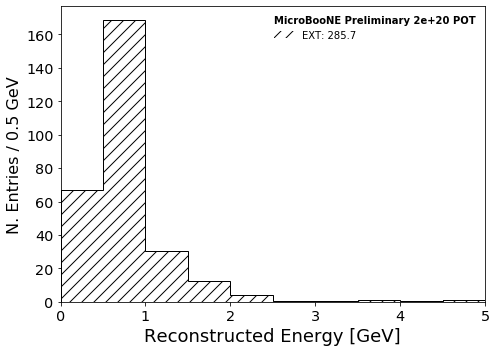

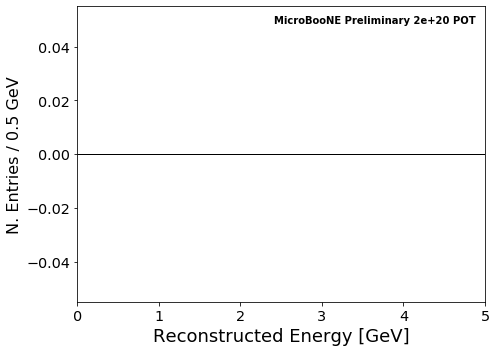

In [49]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    extratio  = 5268051.0/9199232.74
    scalingEXT = 0.98
    
    # NUE
    weights = { "ext" : extratio * SPLIT * scalingEXT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


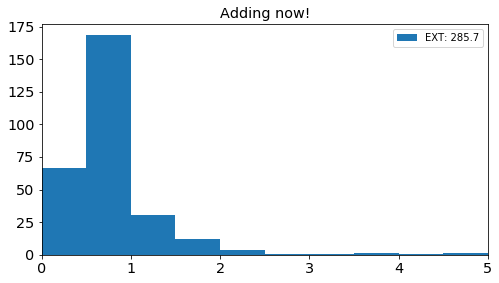

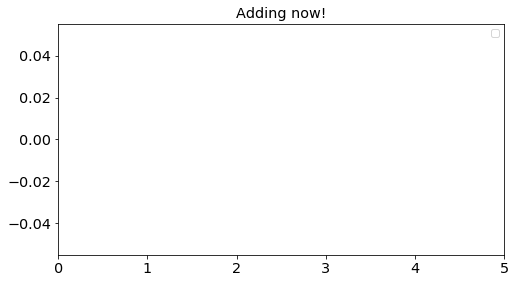

In [50]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [51]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

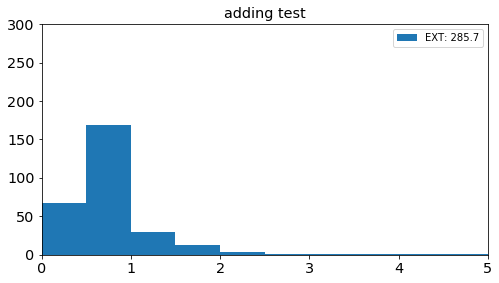

In [52]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 300])

#AngleDiff
#numu_ax1.set_xlim([-1, 1])
#numu_ax1.set_ylim([0, 80])

numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [53]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [25]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Errors

In [28]:
"""
#This is the stat errors on the selected ext

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }

    
    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
    

    
    weights = { #full sample mc = 0.38  
                "numu_ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
"""

n_events here =  904362
n_events/2 here =  180872.0

1.0
1
{'numu_ext': 0.5612087579382191}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_ext

LOOK HERE FOR DETSYS
None
err numu ext: 
[37.47967713 94.486581   17.00758458  6.92901594  2.20468689  0.31495527
  0.31495527  0.62991054  0.31495527  0.62991054]
detsys numu ext: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Returning
{'numu_ext': 0.5612087579382191}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and re

In [30]:
"""
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

numu_ext_stat_errs = total_errs
"""

total errs =  [37.479677128400475, 94.48658099596759, 17.007584579274166, 6.92901593970429, 2.2046868899059104, 0.3149552699865586, 0.3149552699865586, 0.6299105399731172, 0.3149552699865586, 0.6299105399731172]



[ 8.17213817 12.97546251  5.50502252  3.51377186  1.98203464  0.74913868
  0.74913868  1.05944208  0.74913868  1.05944208]


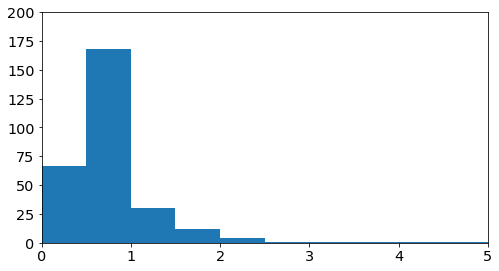

In [57]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 200])


numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


numu_ext_stat_errs = np.sqrt(numu_stacked[0])

print(numu_ext_stat_errs)

In [58]:

np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
           numu_ext_stat_errs,
           delimiter =", ", 
           fmt ='% s')
"""
#########################
#####angleDiff###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
"""
#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

## NUMU_DATA SAMPLE

In [43]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND

#actually fetch datasets
numu_data  = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_data]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali",
        "reco_e","trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['evt', 'topological_score', 'sub', 'trk_sce_start_x_v', 'trk_sce_end_z_v', 'run', 'reco_nu_vtx_y', 'trk_sce_end_y_v', 'pi0truth_elec_etot', 'reco_nu_vtx_x', 'reco_nu_vtx_z', 'npi0', 'CosmicIPAll3D', 'CosmicDirAll3D', 'slnhits', 'flash_pe', 'reco_nu_vtx_sce_x', 'trk_energy_tot', 'reco_nu_vtx_sce_z', 'trk_range_muon_mom_v', 'trk_energy_muon', 'nproton', 'true_e_visible', 'trk_phi', 'shr_energy_tot_cali', '_opfilter_pe_beam', 'ccnc', 'trk_llr_pid_score_v', 'mc_pdg', 'CosmicIP', 'nu_pdg', 'trk_mcs_muon_mom_v', 'npion', 'pion_e', 'trk_sce_end_x_v', 'evnunhits', 'trk_theta', 'nmuon', '_opfilter_pe_veto', 'reco_nu_vtx_sce_y', 'isVtxInFiducial', 'nslice', 'pi0_e', 'muon_e', 'reco_e', 'category', 'slnunhits', 'interaction', 'backtracked_pdg', 'slpdg', 'slclustfrac']


In [44]:
import time
s = time.time()

import pandas as pandas

data_var  = numu_variables + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_data] 
var_v    = [data_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_data = CVDF

s2 = time.time()


trk_llr_pid_v  [[] [] [0.61479425] ... [0.90935814] [] []]
trk_score_v  [[] [] [0.35534355] ... [0.9874813] [] []]
Here:
trk_range_muon_mom_v  [[] [] [0.11552857] ... [0.30664095] [] []]
trk_mcs_muon_mom_v  [[] [] [0.12300007] ... [0.34299913] [] []]


In [45]:
numu_data['pot_scale'] = [1 for x in range(len(numu_data))]

In [46]:
numu_data['totweight_data'] = numu_data['pot_scale']

In [47]:
df_v = [numu_data]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [48]:
df_v = [numu_data]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])

In [49]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_6277/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  5.935187578201294


In [50]:
numu_data["is_signal"]   = numu_data["category"] == 2

In [51]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [52]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [100]:
numu_data.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [101]:
df_v = [numu_data]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
199       0.750087
644       0.221772
861       0.235901
888        0.34727
934       0.458205
            ...   
609743    0.895527
609883     0.28735
610024    0.230272
610173    0.223865
610291    0.230306
Name: muon_mom, Length: 2435, dtype: object


In [102]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [53]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)


Set up complete.

In [54]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_data"  : numu_data
}

pot       =  2e+20

SPLIT = 1.0
scaling = 1

weights = { }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{}


In [55]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

No handles with labels found to put in legend.


n_events here =  610496

1.0
1
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
---------------------------STILL TOGE

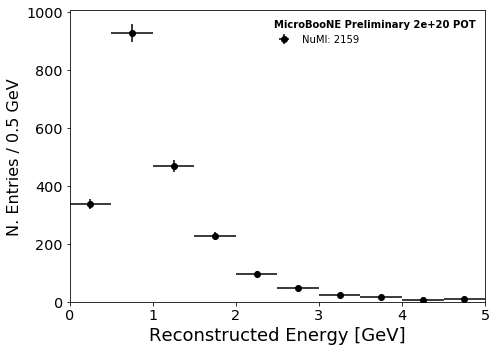

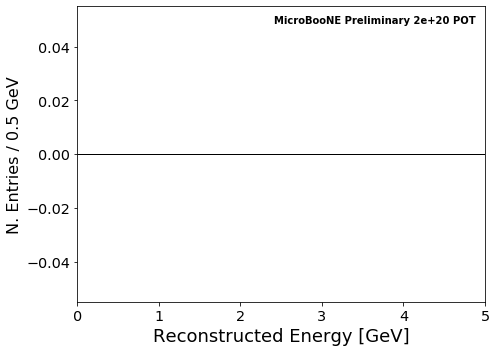

In [58]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_data.iloc[start:end]

    samples = {
        "numu_data": sample_set 
    }

    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


[array([337, 927, 469, 227,  96,  49,  25,  15,   6,   8]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
[array([337, 927, 469, 227,  96,  49,  25,  15,   6,   8]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


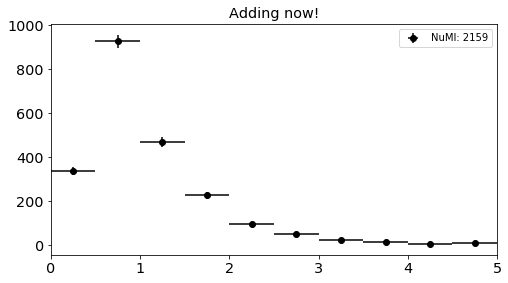

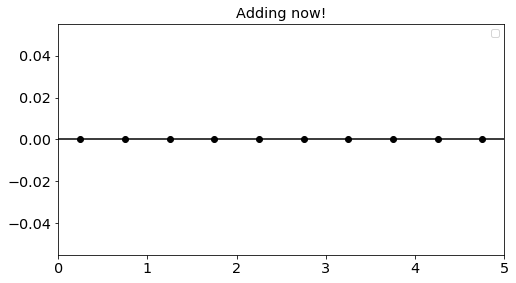

In [59]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    print(varss)
    
    numu_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [60]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[18.35755975 30.4466747  21.65640783 15.06651917  9.79795897  7.
  5.          3.87298335  2.44948974  2.82842712]


[337 927 469 227  96  49  25  15   6   8]


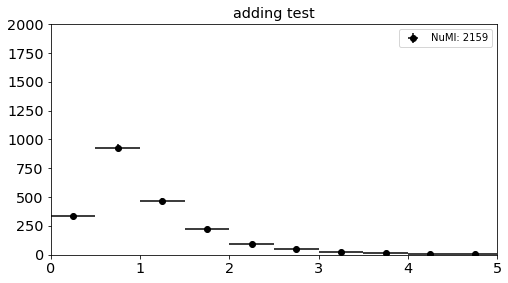

In [61]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 2000])

#AngleDiff
#numu_ax1.set_xlim([-1,1])
#numu_ax1.set_ylim([0, 900])

print(varss_tot)

numu_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [62]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


#######full trueE
vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_07Jul.csv')
########angleDiff
#vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')